 > # **Foodie Project**

**Business case:** There will be a foodie fair in your city next summer, and the organsers have contacted us because they are interested in performing an analysis of the world wide cuisines. They manage to obtain a dataset from different cuisines all over the world, together with the list of the most common ingredients.

Some of our strongest geographic and cultural associations are tied to a region's local foods, so they are interested to know more information regarding them in order to organise the different stands.

In [1]:
import json
import numpy as np 
import pandas as pd 

# text processing libraries
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# sklearn 
from sklearn import model_selection
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV,StratifiedKFold,RandomizedSearchCV

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# Other imports
from collections import Counter
import requests
import imageio
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from matplotlib import pyplot as plt
from PIL import Image


## Import data

In [2]:
import sys
sys.path.append('D:\Data Course\Projects\Food\Food-Project')

from My_functions_EDA import *
from fx_MLRegression import *

In [3]:
# Add the name of the file
data=json.load(open(r'../dataset/Ex 6.1. foodie_dataset.json'))

In [4]:
df = pd.DataFrame(data)

In [5]:
df

id      cuisine                                        ingredients
0      10259        greek  [romaine lettuce, black olives, grape tomatoes...
1      25693  southern_us  [plain flour, ground pepper, salt, tomatoes, g...
2      20130     filipino  [eggs, pepper, salt, mayonaise, cooking oil, g...
3      22213       indian                [water, vegetable oil, wheat, salt]
4      13162       indian  [black pepper, shallots, cornflour, cayenne pe...
...      ...          ...                                                ...
39769  29109        irish  [light brown sugar, granulated sugar, butter, ...
39770  11462      italian  [KRAFT Zesty Italian Dressing, purple onion, b...
39771   2238        irish  [eggs, citrus fruit, raisins, sourdough starte...
39772  41882      chinese  [boneless chicken skinless thigh, minced garli...
39773   2362      mexican  [green chile, jalapeno chilies, onions, ground...

[39774 rows x 3 columns]

In [6]:
#Missing values in training set
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39774 entries, 0 to 39773
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           39774 non-null  int64 
 1   cuisine      39774 non-null  object
 2   ingredients  39774 non-null  object
dtypes: int64(1), object(2)
memory usage: 932.3+ KB


# Exploring cuisine column

In [7]:
df.cuisine.value_counts()

italian         7838
mexican         6438
southern_us     4320
indian          3003
chinese         2673
french          2646
cajun_creole    1546
thai            1539
japanese        1423
greek           1175
spanish          989
korean           830
vietnamese       825
moroccan         821
british          804
filipino         755
irish            667
jamaican         526
russian          489
brazilian        467
Name: cuisine, dtype: int64

In [8]:
fig = px.bar(x = df['cuisine'].value_counts().index, y = df['cuisine'].value_counts(), template="plotly_white",
            labels={'x':'Cuisine', 'y': 'Amount of Recipies'})
fig.show()

# Cleaning Ingredients Column

In [9]:
#Create a new column -called Clean - where the ingredients are a string not a list
df['clean'] = df.ingredients.apply(', '.join)

# Modify the Clean Column replacing the ',' by the key word 'hola' -Hello in Spanish- 
# the reason is have a work-key total different to the ingredients 
# and using a word I can clean the special characters as dots and comas
df['clean'] = df['clean'].str.replace(',',' hola')

In [10]:
type(df.ingredients[0])

list

In [11]:
type(df.clean[0])

str

In [12]:
#Generate a Counter to check what are the word most frecuent, using the key-word 'hola' as splitter
from collections import Counter
vocab = Counter()
for recipe in df['clean']:
    for word in recipe.split('hola'):
        vocab[word.strip()] += 1

In [13]:
#The problem now is the 'salt' and 'salts' are count as different word being the same ingredient
vocab.most_common(15)

[('salt', 18049),
 ('onions', 7972),
 ('olive oil', 7972),
 ('water', 7457),
 ('garlic', 7380),
 ('sugar', 6434),
 ('garlic cloves', 6237),
 ('butter', 4848),
 ('ground black pepper', 4785),
 ('all-purpose flour', 4632),
 ('pepper', 4438),
 ('vegetable oil', 4385),
 ('eggs', 3388),
 ('soy sauce', 3296),
 ('kosher salt', 3113)]

In [14]:
#Tokenized the problem to fix that problem
def tokenize(text):
    tokens=re.split('\W+',text)
    return tokens 

df['tokenized_text']=df['clean'].apply(lambda row : tokenize(row.lower()))

In [15]:
#Remove the stop words to more uniformity in the text
def remove_stopwords(text):
    stopwords=nltk.corpus.stopwords.words('english')

    clean_text=[word for word in text if word not in stopwords]
    return clean_text 

df['w_stop']=df['tokenized_text'].apply(lambda row : remove_stopwords(row))

In [16]:
df

id      cuisine                                        ingredients  \
0      10259        greek  [romaine lettuce, black olives, grape tomatoes...   
1      25693  southern_us  [plain flour, ground pepper, salt, tomatoes, g...   
2      20130     filipino  [eggs, pepper, salt, mayonaise, cooking oil, g...   
3      22213       indian                [water, vegetable oil, wheat, salt]   
4      13162       indian  [black pepper, shallots, cornflour, cayenne pe...   
...      ...          ...                                                ...   
39769  29109        irish  [light brown sugar, granulated sugar, butter, ...   
39770  11462      italian  [KRAFT Zesty Italian Dressing, purple onion, b...   
39771   2238        irish  [eggs, citrus fruit, raisins, sourdough starte...   
39772  41882      chinese  [boneless chicken skinless thigh, minced garli...   
39773   2362      mexican  [green chile, jalapeno chilies, onions, ground...   

                                                   clean  \
0      romaine lettuce hola black olives hola grape t...   
1      plain flour hola ground pepper hola salt hola ...   
2      eggs hola pepper hola salt hola mayonaise hola...   
3          water hola vegetable oil hola wheat hola salt   
4      black pepper hola shallots hola cornflour hola...   
...                                                  ...   
39769  light brown sugar hola granulated sugar hola b...   
39770  KRAFT Zesty Italian Dressing hola purple onion...   
39771  eggs hola citrus fruit hola raisins hola sourd...   
39772  boneless chicken skinless thigh hola minced ga...   
39773  green chile hola jalapeno chilies hola onions ...   

                                          tokenized_text  \
0      [romaine, lettuce, hola, black, olives, hola, ...   
1      [plain, flour, hola, ground, pepper, hola, sal...   
2      [eggs, hola, pepper, hola, salt, hola, mayonai...   
3      [water, hola, vegetable, oil, hola, wheat, hol...   
4      [black, pepper, hola, shallots, hola, cornflou...   
...                                                  ...   
39769  [light, brown, sugar, hola, granulated, sugar,...   
39770  [kraft, zesty, italian, dressing, hola, purple...   
39771  [eggs, hola, citrus, fruit, hola, raisins, hol...   
39772  [boneless, chicken, skinless, thigh, hola, min...   
39773  [green, chile, hola, jalapeno, chilies, hola, ...   

                                                  w_stop  
0      [romaine, lettuce, hola, black, olives, hola, ...  
1      [plain, flour, hola, ground, pepper, hola, sal...  
2      [eggs, hola, pepper, hola, salt, hola, mayonai...  
3      [water, hola, vegetable, oil, hola, wheat, hol...  
4      [black, pepper, hola, shallots, hola, cornflou...  
...                                                  ...  
39769  [light, brown, sugar, hola, granulated, sugar,...  
39770  [kraft, zesty, italian, dressing, hola, purple...  
39771  [eggs, hola, citrus, fruit, hola, raisins, hol...  
39772  [boneless, chicken, skinless, thigh, hola, min...  
39773  [green, chile, hola, jalapeno, chilies, hola, ...  

[39774 rows x 6 columns]

In [17]:
#Now Lemmatize the ingredients
lemmatizer = WordNetLemmatizer()
def lemmatizer2(tokenized_text):
    lematize_text=[lemmatizer.lemmatize(word) for word in tokenized_text]
    return lematize_text

df['lemmatizer_text']=df['w_stop'].apply(lambda row : lemmatizer2(row))
df.head()

id      cuisine                                        ingredients  \
0  10259        greek  [romaine lettuce, black olives, grape tomatoes...   
1  25693  southern_us  [plain flour, ground pepper, salt, tomatoes, g...   
2  20130     filipino  [eggs, pepper, salt, mayonaise, cooking oil, g...   
3  22213       indian                [water, vegetable oil, wheat, salt]   
4  13162       indian  [black pepper, shallots, cornflour, cayenne pe...   

                                               clean  \
0  romaine lettuce hola black olives hola grape t...   
1  plain flour hola ground pepper hola salt hola ...   
2  eggs hola pepper hola salt hola mayonaise hola...   
3      water hola vegetable oil hola wheat hola salt   
4  black pepper hola shallots hola cornflour hola...   

                                      tokenized_text  \
0  [romaine, lettuce, hola, black, olives, hola, ...   
1  [plain, flour, hola, ground, pepper, hola, sal...   
2  [eggs, hola, pepper, hola, salt, hola, mayonai...   
3  [water, hola, vegetable, oil, hola, wheat, hol...   
4  [black, pepper, hola, shallots, hola, cornflou...   

                                              w_stop  \
0  [romaine, lettuce, hola, black, olives, hola, ...   
1  [plain, flour, hola, ground, pepper, hola, sal...   
2  [eggs, hola, pepper, hola, salt, hola, mayonai...   
3  [water, hola, vegetable, oil, hola, wheat, hol...   
4  [black, pepper, hola, shallots, hola, cornflou...   

                                     lemmatizer_text  
0  [romaine, lettuce, hola, black, olive, hola, g...  
1  [plain, flour, hola, ground, pepper, hola, sal...  
2  [egg, hola, pepper, hola, salt, hola, mayonais...  
3  [water, hola, vegetable, oil, hola, wheat, hol...  
4  [black, pepper, hola, shallot, hola, cornflour...

In [18]:
#And after that transformation we trasform the list of without stopwords -w_stop- into string 
df['final'] = df.lemmatizer_text.apply(' '.join)

In [19]:
type(df.lemmatizer_text[35563])

list

In [20]:
type(df.final[35563])

str

In [21]:
#And now we can select a word to filter
df[df.final.str.contains('chicken')]

id     cuisine                                        ingredients  \
2      20130    filipino  [eggs, pepper, salt, mayonaise, cooking oil, g...   
4      13162      indian  [black pepper, shallots, cornflour, cayenne pe...   
14     31908     italian  [fresh parmesan cheese, butter, all-purpose fl...   
17      1420     italian  [italian seasoning, broiler-fryer chicken, may...   
19      8152  vietnamese  [soy sauce, vegetable oil, red bell pepper, ch...   
...      ...         ...                                                ...   
39754  27082  vietnamese  [jasmine rice, bay leaves, sticky rice, rotiss...   
39761   6487     chinese  [honey, chicken breast halves, cilantro leaves...   
39762  26646      indian  [curry powder, salt, chicken, water, vegetable...   
39768   7377     mexican  [shredded cheddar cheese, crushed cheese crack...   
39772  41882     chinese  [boneless chicken skinless thigh, minced garli...   

                                                   clean  \
2      eggs hola pepper hola salt hola mayonaise hola...   
4      black pepper hola shallots hola cornflour hola...   
14     fresh parmesan cheese hola butter hola all-pur...   
17     italian seasoning hola broiler-fryer chicken h...   
19     soy sauce hola vegetable oil hola red bell pep...   
...                                                  ...   
39754  jasmine rice hola bay leaves hola sticky rice ...   
39761  honey hola chicken breast halves hola cilantro...   
39762  curry powder hola salt hola chicken hola water...   
39768  shredded cheddar cheese hola crushed cheese cr...   
39772  boneless chicken skinless thigh hola minced ga...   

                                          tokenized_text  \
2      [eggs, hola, pepper, hola, salt, hola, mayonai...   
4      [black, pepper, hola, shallots, hola, cornflou...   
14     [fresh, parmesan, cheese, hola, butter, hola, ...   
17     [italian, seasoning, hola, broiler, fryer, chi...   
19     [soy, sauce, hola, vegetable, oil, hola, red, ...   
...                                                  ...   
39754  [jasmine, rice, hola, bay, leaves, hola, stick...   
39761  [honey, hola, chicken, breast, halves, hola, c...   
39762  [curry, powder, hola, salt, hola, chicken, hol...   
39768  [shredded, cheddar, cheese, hola, crushed, che...   
39772  [boneless, chicken, skinless, thigh, hola, min...   

                                                  w_stop  \
2      [eggs, hola, pepper, hola, salt, hola, mayonai...   
4      [black, pepper, hola, shallots, hola, cornflou...   
14     [fresh, parmesan, cheese, hola, butter, hola, ...   
17     [italian, seasoning, hola, broiler, fryer, chi...   
19     [soy, sauce, hola, vegetable, oil, hola, red, ...   
...                                                  ...   
39754  [jasmine, rice, hola, bay, leaves, hola, stick...   
39761  [honey, hola, chicken, breast, halves, hola, c...   
39762  [curry, powder, hola, salt, hola, chicken, hol...   
39768  [shredded, cheddar, cheese, hola, crushed, che...   
39772  [boneless, chicken, skinless, thigh, hola, min...   

                                         lemmatizer_text  \
2      [egg, hola, pepper, hola, salt, hola, mayonais...   
4      [black, pepper, hola, shallot, hola, cornflour...   
14     [fresh, parmesan, cheese, hola, butter, hola, ...   
17     [italian, seasoning, hola, broiler, fryer, chi...   
19     [soy, sauce, hola, vegetable, oil, hola, red, ...   
...                                                  ...   
39754  [jasmine, rice, hola, bay, leaf, hola, sticky,...   
39761  [honey, hola, chicken, breast, half, hola, cil...   
39762  [curry, powder, hola, salt, hola, chicken, hol...   
39768  [shredded, cheddar, cheese, hola, crushed, che...   
39772  [boneless, chicken, skinless, thigh, hola, min...   

                                                   final  
2      egg hola pepper hola salt hola mayonaise hola ...  
4      black pepper hola shallot hola cornflour hola ...  


In [22]:
# Replace the 'hola' by a , and end the cleaning
df['final']= df['final'].str.replace(' hola' ,',')
df.head()

id      cuisine                                        ingredients  \
0  10259        greek  [romaine lettuce, black olives, grape tomatoes...   
1  25693  southern_us  [plain flour, ground pepper, salt, tomatoes, g...   
2  20130     filipino  [eggs, pepper, salt, mayonaise, cooking oil, g...   
3  22213       indian                [water, vegetable oil, wheat, salt]   
4  13162       indian  [black pepper, shallots, cornflour, cayenne pe...   

                                               clean  \
0  romaine lettuce hola black olives hola grape t...   
1  plain flour hola ground pepper hola salt hola ...   
2  eggs hola pepper hola salt hola mayonaise hola...   
3      water hola vegetable oil hola wheat hola salt   
4  black pepper hola shallots hola cornflour hola...   

                                      tokenized_text  \
0  [romaine, lettuce, hola, black, olives, hola, ...   
1  [plain, flour, hola, ground, pepper, hola, sal...   
2  [eggs, hola, pepper, hola, salt, hola, mayonai...   
3  [water, hola, vegetable, oil, hola, wheat, hol...   
4  [black, pepper, hola, shallots, hola, cornflou...   

                                              w_stop  \
0  [romaine, lettuce, hola, black, olives, hola, ...   
1  [plain, flour, hola, ground, pepper, hola, sal...   
2  [eggs, hola, pepper, hola, salt, hola, mayonai...   
3  [water, hola, vegetable, oil, hola, wheat, hol...   
4  [black, pepper, hola, shallots, hola, cornflou...   

                                     lemmatizer_text  \
0  [romaine, lettuce, hola, black, olive, hola, g...   
1  [plain, flour, hola, ground, pepper, hola, sal...   
2  [egg, hola, pepper, hola, salt, hola, mayonais...   
3  [water, hola, vegetable, oil, hola, wheat, hol...   
4  [black, pepper, hola, shallot, hola, cornflour...   

                                               final  
0  romaine lettuce, black olive, grape tomato, ga...  
1  plain flour, ground pepper, salt, tomato, grou...  
2  egg, pepper, salt, mayonaise, cooking oil, gre...  
3                  water, vegetable oil, wheat, salt  
4  black pepper, shallot, cornflour, cayenne pepp...

## Generate the New Data

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39774 entries, 0 to 39773
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               39774 non-null  int64 
 1   cuisine          39774 non-null  object
 2   ingredients      39774 non-null  object
 3   clean            39774 non-null  object
 4   tokenized_text   39774 non-null  object
 5   w_stop           39774 non-null  object
 6   lemmatizer_text  39774 non-null  object
 7   final            39774 non-null  object
dtypes: int64(1), object(7)
memory usage: 2.4+ MB


In [24]:
data= df.copy()

In [25]:
data.drop(axis = 1, columns=["clean", "id", "tokenized_text","w_stop"], inplace= True)

In [26]:
data.loc[143,:]

cuisine                                                 mexican
ingredients                [granulated sugar, large egg whites]
lemmatizer_text    [granulated, sugar, hola, large, egg, white]
final                         granulated sugar, large egg white
Name: 143, dtype: object

In [27]:
data.to_csv('../dataset/00-Data_Clean.csv')

# Analyzing the new Data 

In [28]:
df_1 = pd.read_csv('../dataset/00-Data_Clean.csv')
df_1

Unnamed: 0      cuisine  \
0               0        greek   
1               1  southern_us   
2               2     filipino   
3               3       indian   
4               4       indian   
...           ...          ...   
39769       39769        irish   
39770       39770      italian   
39771       39771        irish   
39772       39772      chinese   
39773       39773      mexican   

                                             ingredients  \
0      ['romaine lettuce', 'black olives', 'grape tom...   
1      ['plain flour', 'ground pepper', 'salt', 'toma...   
2      ['eggs', 'pepper', 'salt', 'mayonaise', 'cooki...   
3            ['water', 'vegetable oil', 'wheat', 'salt']   
4      ['black pepper', 'shallots', 'cornflour', 'cay...   
...                                                  ...   
39769  ['light brown sugar', 'granulated sugar', 'but...   
39770  ['KRAFT Zesty Italian Dressing', 'purple onion...   
39771  ['eggs', 'citrus fruit', 'raisins', 'sourdough...   
39772  ['boneless chicken skinless thigh', 'minced ga...   
39773  ['green chile', 'jalapeno chilies', 'onions', ...   

                                         lemmatizer_text  \
0      ['romaine', 'lettuce', 'hola', 'black', 'olive...   
1      ['plain', 'flour', 'hola', 'ground', 'pepper',...   
2      ['egg', 'hola', 'pepper', 'hola', 'salt', 'hol...   
3      ['water', 'hola', 'vegetable', 'oil', 'hola', ...   
4      ['black', 'pepper', 'hola', 'shallot', 'hola',...   
...                                                  ...   
39769  ['light', 'brown', 'sugar', 'hola', 'granulate...   
39770  ['kraft', 'zesty', 'italian', 'dressing', 'hol...   
39771  ['egg', 'hola', 'citrus', 'fruit', 'hola', 'ra...   
39772  ['boneless', 'chicken', 'skinless', 'thigh', '...   
39773  ['green', 'chile', 'hola', 'jalapeno', 'chilie...   

                                                   final  
0      romaine lettuce, black olive, grape tomato, ga...  
1      plain flour, ground pepper, salt, tomato, grou...  
2      egg, pepper, salt, mayonaise, cooking oil, gre...  
3                      water, vegetable oil, wheat, salt  
4      black pepper, shallot, cornflour, cayenne pepp...  
...                                                  ...  
39769  light brown sugar, granulated sugar, butter, w...  
39770  kraft zesty italian dressing, purple onion, br...  
39771  egg, citrus fruit, raisin, sourdough starter, ...  
39772  boneless chicken skinless thigh, minced garlic...  
39773  green chile, jalapeno chilies, onion, ground b...  

[39774 rows x 5 columns]

In [29]:
# checking shape ...
print("The dataset has {} rows and {} columns.".format(*df_1.shape))

# ... and duplicates
print("It contains {} duplicates.".format(df_1.duplicated().sum()))

The dataset has 39774 rows and 5 columns.
It contains 0 duplicates.


In [30]:
# Drop the 'unnamed' column
df_1.drop(columns="Unnamed: 0",inplace= True)

In [31]:
df_1

cuisine                                        ingredients  \
0            greek  ['romaine lettuce', 'black olives', 'grape tom...   
1      southern_us  ['plain flour', 'ground pepper', 'salt', 'toma...   
2         filipino  ['eggs', 'pepper', 'salt', 'mayonaise', 'cooki...   
3           indian        ['water', 'vegetable oil', 'wheat', 'salt']   
4           indian  ['black pepper', 'shallots', 'cornflour', 'cay...   
...            ...                                                ...   
39769        irish  ['light brown sugar', 'granulated sugar', 'but...   
39770      italian  ['KRAFT Zesty Italian Dressing', 'purple onion...   
39771        irish  ['eggs', 'citrus fruit', 'raisins', 'sourdough...   
39772      chinese  ['boneless chicken skinless thigh', 'minced ga...   
39773      mexican  ['green chile', 'jalapeno chilies', 'onions', ...   

                                         lemmatizer_text  \
0      ['romaine', 'lettuce', 'hola', 'black', 'olive...   
1      ['plain', 'flour', 'hola', 'ground', 'pepper',...   
2      ['egg', 'hola', 'pepper', 'hola', 'salt', 'hol...   
3      ['water', 'hola', 'vegetable', 'oil', 'hola', ...   
4      ['black', 'pepper', 'hola', 'shallot', 'hola',...   
...                                                  ...   
39769  ['light', 'brown', 'sugar', 'hola', 'granulate...   
39770  ['kraft', 'zesty', 'italian', 'dressing', 'hol...   
39771  ['egg', 'hola', 'citrus', 'fruit', 'hola', 'ra...   
39772  ['boneless', 'chicken', 'skinless', 'thigh', '...   
39773  ['green', 'chile', 'hola', 'jalapeno', 'chilie...   

                                                   final  
0      romaine lettuce, black olive, grape tomato, ga...  
1      plain flour, ground pepper, salt, tomato, grou...  
2      egg, pepper, salt, mayonaise, cooking oil, gre...  
3                      water, vegetable oil, wheat, salt  
4      black pepper, shallot, cornflour, cayenne pepp...  
...                                                  ...  
39769  light brown sugar, granulated sugar, butter, w...  
39770  kraft zesty italian dressing, purple onion, br...  
39771  egg, citrus fruit, raisin, sourdough starter, ...  
39772  boneless chicken skinless thigh, minced garlic...  
39773  green chile, jalapeno chilies, onion, ground b...  

[39774 rows x 4 columns]

In [32]:
print("It contains {} different types of cuisine.".format(df_1.cuisine.nunique()))
print(df_1.cuisine.unique())

It contains 20 different types of cuisine.
['greek' 'southern_us' 'filipino' 'indian' 'jamaican' 'spanish' 'italian'
 'mexican' 'chinese' 'british' 'thai' 'vietnamese' 'cajun_creole'
 'brazilian' 'french' 'japanese' 'irish' 'korean' 'moroccan' 'russian']


In [33]:
df_1.cuisine.value_counts()

italian         7838
mexican         6438
southern_us     4320
indian          3003
chinese         2673
french          2646
cajun_creole    1546
thai            1539
japanese        1423
greek           1175
spanish          989
korean           830
vietnamese       825
moroccan         821
british          804
filipino         755
irish            667
jamaican         526
russian          489
brazilian        467
Name: cuisine, dtype: int64

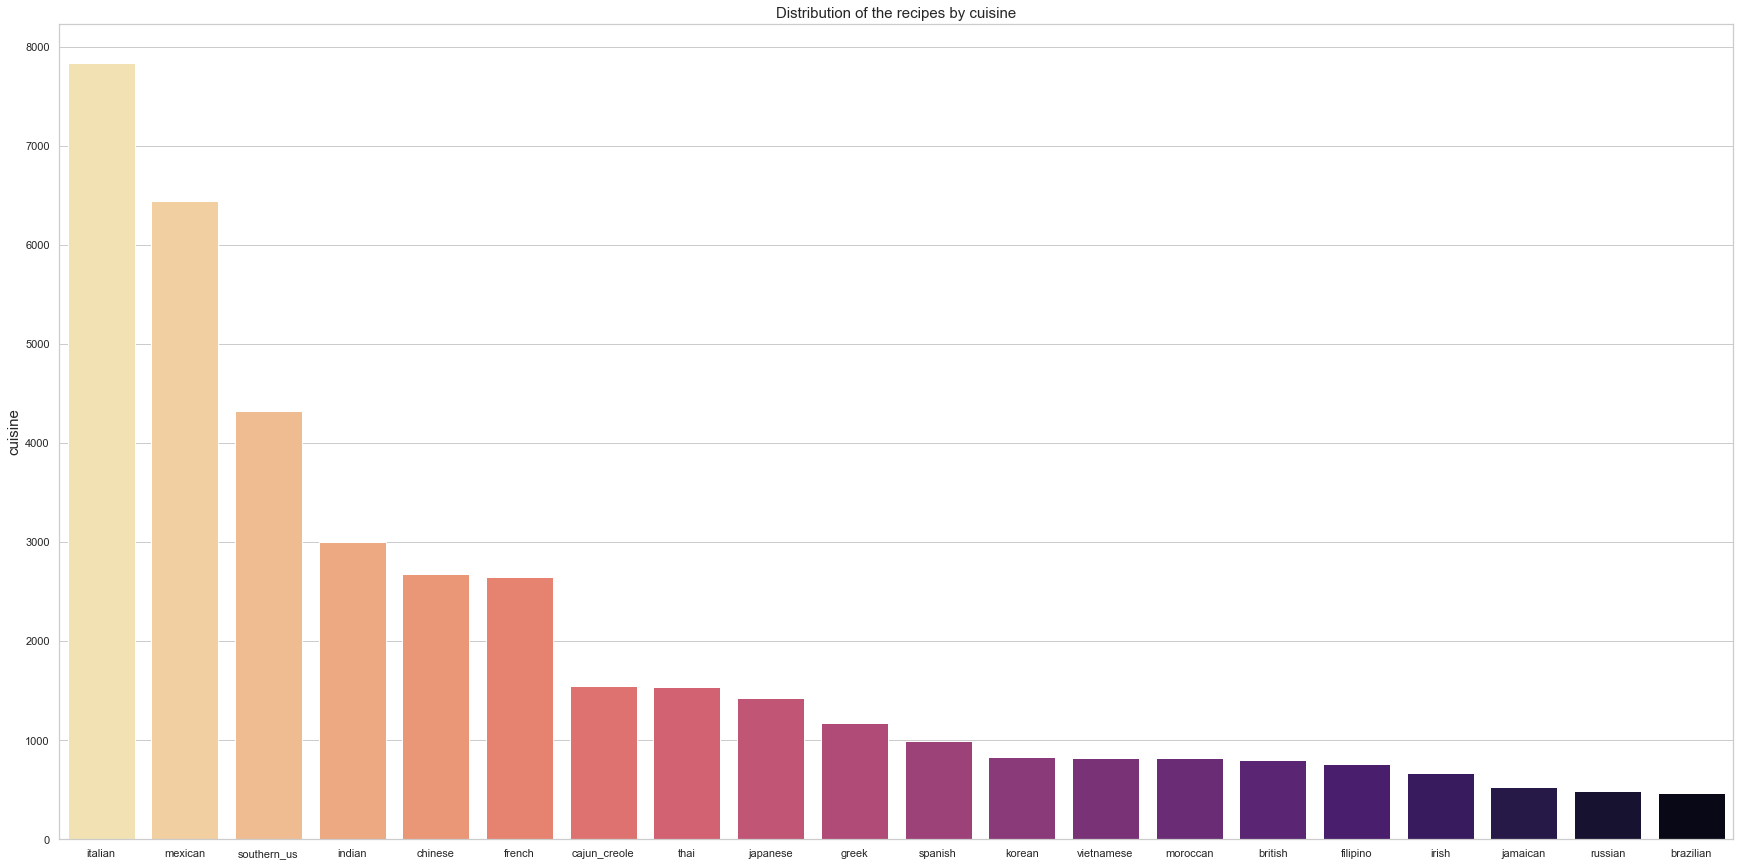

In [34]:
sns.set(rc={'figure.figsize':(30,15),
            'axes.labelsize': 15, 
            'font.size': 30, 
            'legend.fontsize': 12, 
            'axes.titlesize':15,
            'figure.facecolor': 'white',
            'font.family': ['sans-serif'],
            'legend.fancybox': True,
            'lines.color': 'C0',
            'xaxis.labellocation': 'center',
            'xtick.alignment': 'center',
            'legend.title_fontsize': 50,
            'legend.edgecolor': '0.9',
            'animation.ffmpeg_path': 'ffmpeg',
           })    
sns.set_style("whitegrid")
plt.title('Distribution of the recipes by cuisine')



sns_plot = sns.barplot(df_1['cuisine'].value_counts().index,
            df_1['cuisine'].value_counts(),palette='magma_r')

In [35]:
sns_plot.figure.savefig("cuisine_distribution.png")

## Seeing the Lenght of the Recipes

In [36]:
# Created the column length of the recipes 
df_1['Len'] = df_1['final'].apply(lambda row: len(row.split(', ')))

In [37]:
# Check the values of leght
df_1.Len.value_counts().sort_values(ascending=False)

9     3758
10    3677
8     3541
11    3514
7     3320
12    3144
13    2690
6     2659
14    2288
5     1874
15    1810
16    1441
17    1156
4     1113
18     901
19     603
3      548
20     514
21     313
22     218
2      193
23     143
24      91
25      74
26      46
28      27
1       22
29      21
27      20
30      15
31      11
33       4
32       4
36       4
40       3
35       3
34       3
38       2
49       2
52       1
65       1
43       1
59       1
Name: Len, dtype: int64

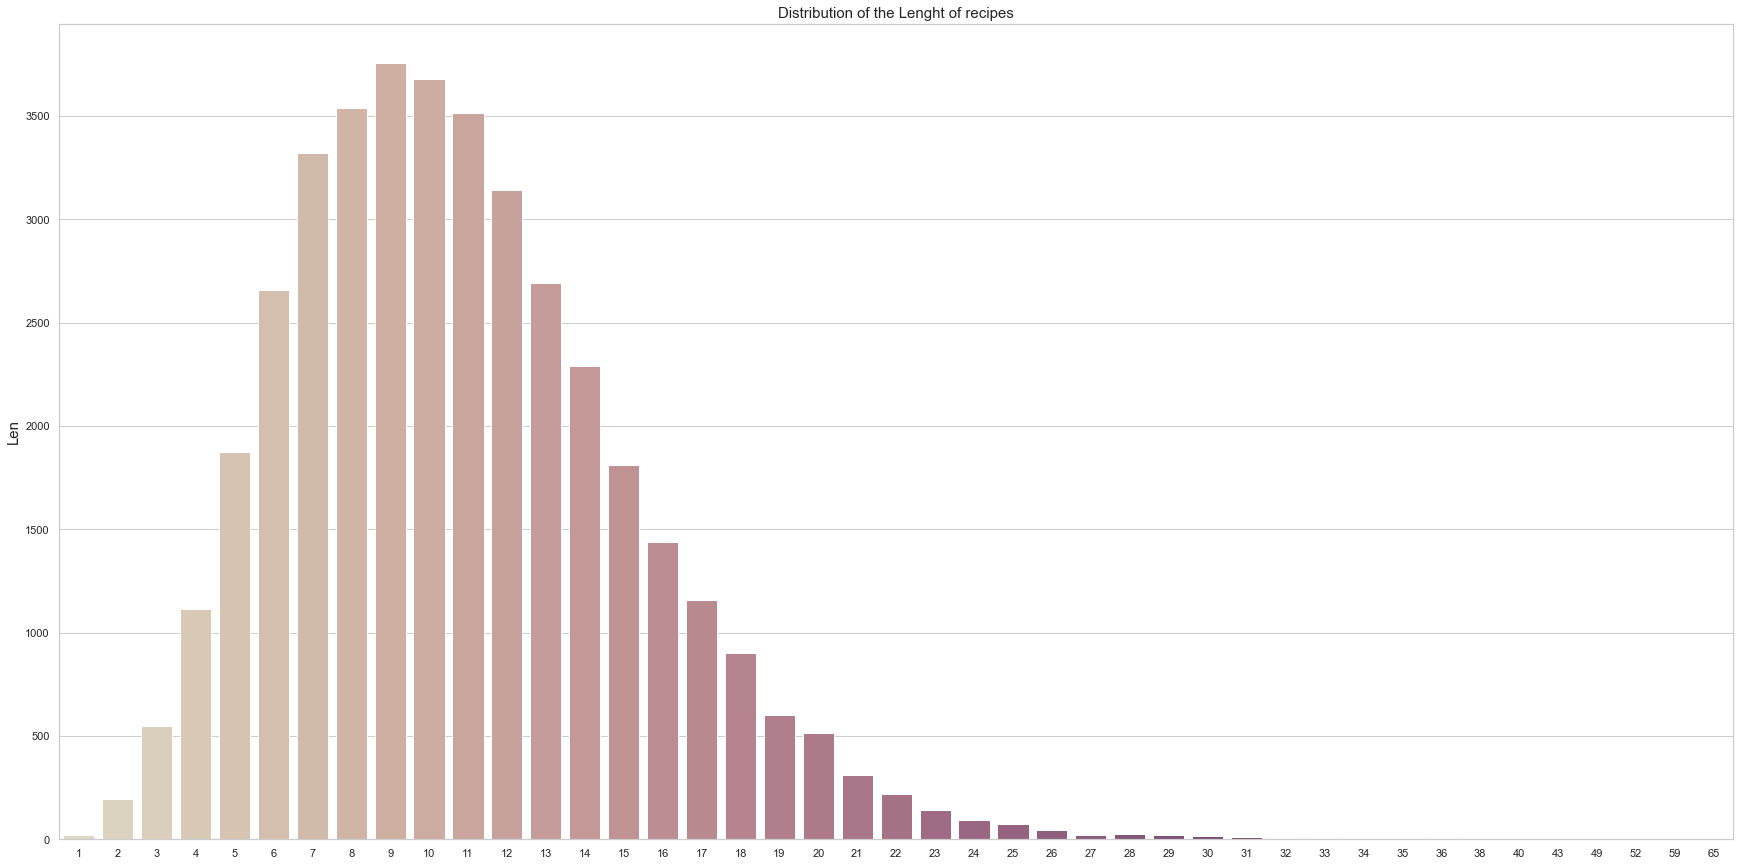

In [38]:
sns.set(rc={'figure.figsize':(30,15),
            'axes.labelsize': 15, 
            'font.size': 30, 
            'legend.fontsize': 16, 
            'axes.titlesize':15,
            'figure.facecolor': 'white',
            'font.family': ['sans-serif'],
            'legend.fancybox': True,
            'lines.color': 'C0',
            'xaxis.labellocation': 'center',
            'xtick.alignment': 'center',
            'legend.title_fontsize': 15,
            'legend.edgecolor': '0.9',
            'animation.ffmpeg_path': 'ffmpeg',
           })    
sns.set_style("whitegrid")
plt.title('Distribution of the Lenght of recipes')



sns_plot = sns.barplot(df_1.Len.value_counts().index,
            df_1['Len'].value_counts(),palette="ch:s=-.2,r=.6")

In [39]:
sns_plot.figure.savefig("lenght_distribution.png")

In [40]:
# Seeing the max and min by cuisine
a = df_1.groupby(['cuisine']).agg({'Len': [np.count_nonzero,np.min,np.max,np.mean,]})
a

Len                     
             count_nonzero amin amax       mean
cuisine                                        
brazilian              467    2   59   9.526767
british                804    2   30   9.712687
cajun_creole          1546    2   31  12.634541
chinese               2673    2   38  11.994014
filipino               755    2   38  10.006623
french                2646    1   31   9.828798
greek                 1175    1   27  10.194894
indian                3003    1   49  12.708292
irish                  667    2   27   9.308846
italian               7838    1   65   9.934294
jamaican               526    2   35  12.224335
japanese              1423    1   34   9.737878
korean                 830    2   29  11.284337
mexican               6438    1   52  10.902454
moroccan               821    2   31  12.913520
russian                489    2   25  10.235174
southern_us           4320    1   40   9.652778
spanish                989    1   35  10.442872
thai                  1539    1   40  12.555556
vietnamese             825    1   31  12.682424

### Reduce the Size of Recipies

In [41]:
df_less = df_1[df_1.Len < 20]
df_less.reset_index(drop=True, inplace = True)
print("We have", df_less.shape[0] , "recipes with less than 16 elements, and We had" , df_1.shape[0])

We have 38252 recipes with less than 16 elements, and We had 39774


In [42]:
df_less

cuisine                                        ingredients  \
0            greek  ['romaine lettuce', 'black olives', 'grape tom...   
1      southern_us  ['plain flour', 'ground pepper', 'salt', 'toma...   
2         filipino  ['eggs', 'pepper', 'salt', 'mayonaise', 'cooki...   
3           indian        ['water', 'vegetable oil', 'wheat', 'salt']   
4         jamaican  ['plain flour', 'sugar', 'butter', 'eggs', 'fr...   
...            ...                                                ...   
38247      mexican  ['shredded cheddar cheese', 'crushed cheese cr...   
38248        irish  ['light brown sugar', 'granulated sugar', 'but...   
38249      italian  ['KRAFT Zesty Italian Dressing', 'purple onion...   
38250        irish  ['eggs', 'citrus fruit', 'raisins', 'sourdough...   
38251      mexican  ['green chile', 'jalapeno chilies', 'onions', ...   

                                         lemmatizer_text  \
0      ['romaine', 'lettuce', 'hola', 'black', 'olive...   
1      ['plain', 'flour', 'hola', 'ground', 'pepper',...   
2      ['egg', 'hola', 'pepper', 'hola', 'salt', 'hol...   
3      ['water', 'hola', 'vegetable', 'oil', 'hola', ...   
4      ['plain', 'flour', 'hola', 'sugar', 'hola', 'b...   
...                                                  ...   
38247  ['shredded', 'cheddar', 'cheese', 'hola', 'cru...   
38248  ['light', 'brown', 'sugar', 'hola', 'granulate...   
38249  ['kraft', 'zesty', 'italian', 'dressing', 'hol...   
38250  ['egg', 'hola', 'citrus', 'fruit', 'hola', 'ra...   
38251  ['green', 'chile', 'hola', 'jalapeno', 'chilie...   

                                                   final  Len  
0      romaine lettuce, black olive, grape tomato, ga...    9  
1      plain flour, ground pepper, salt, tomato, grou...   11  
2      egg, pepper, salt, mayonaise, cooking oil, gre...   12  
3                      water, vegetable oil, wheat, salt    4  
4      plain flour, sugar, butter, egg, fresh ginger ...   12  
...                                                  ...  ...  
38247  shredded cheddar cheese, crushed cheese cracke...   10  
38248  light brown sugar, granulated sugar, butter, w...   12  
38249  kraft zesty italian dressing, purple onion, br...    7  
38250  egg, citrus fruit, raisin, sourdough starter, ...   12  
38251  green chile, jalapeno chilies, onion, ground b...   12  

[38252 rows x 5 columns]

<Figure size 576x360 with 0 Axes>

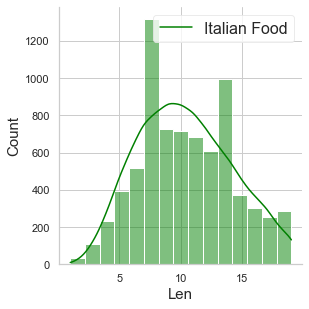

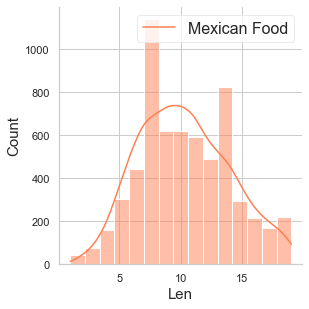

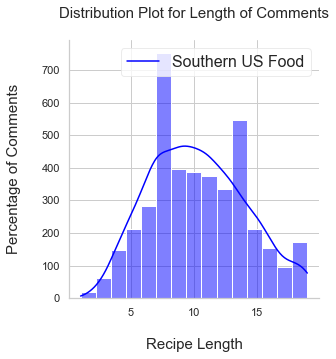

In [43]:
sns.set_style("whitegrid")
plt.figure(figsize=(8,5))

sns.displot(df_less.Len[df_1.cuisine == "italian"], kde=True, bins =15, color='green')
plt.legend([ 'Italian Food'])
sns.displot(df_less.Len[df_1.cuisine == "mexican"], kde=True, bins =15,  color='coral')
plt.legend(['Mexican Food'])
sns.displot(df_less.Len[df_1.cuisine == "southern_us"], kde=True, bins =15, color='blue')
plt.legend([ 'Southern US Food'])

plt.title('Distribution Plot for Length of Comments\n')

plt.xlabel('\nRecipe Length')
plt.ylabel('Percentage of Comments\n');

In [44]:
df_less.groupby(['cuisine']).agg({'Len': [np.min,np.max,np.mean, np.count_nonzero]} )

Len                              
             amin amax       mean count_nonzero
cuisine                                        
brazilian       2   19   9.057143           455
british         2   19   9.470886           790
cajun_creole    2   19  11.921582          1441
chinese         2   19  11.616311          2575
filipino        2   19   9.744249           739
french          1   19   9.537926          2584
greek           1   19  10.040552          1159
indian          1   19  11.726706          2726
irish           2   19   9.189107           661
italian         1   19   9.711019          7696
jamaican        2   19  11.466395           491
japanese        1   19   9.464849          1394
korean          2   19  11.011111           810
mexican         1   19  10.288260          6116
moroccan        2   19  12.068091           749
russian         2   19   9.956067           478
southern_us     1   19   9.438324          4248
spanish         1   19  10.151139           966
thai            1   19  11.895906          1441
vietnamese      1   19  11.519782           733

In [45]:
# see the recipies with less than 3 ingredients
df_less[df_less.Len < 7]

cuisine                                        ingredients  \
3           indian        ['water', 'vegetable oil', 'wheat', 'salt']   
8          italian  ['chopped tomatoes', 'fresh basil', 'garlic', ...   
15         british  ['greek yogurt', 'lemon curd', 'confectioners ...   
16         italian  ['italian seasoning', 'broiler-fryer chicken',...   
17            thai  ['sugar', 'hot chili', 'asian fish sauce', 'li...   
...            ...                                                ...   
38224      spanish  ['quinoa', 'extra-virgin olive oil', 'fresh th...   
38226     moroccan  ['water', 'sugar', 'grated lemon zest', 'butte...   
38231  southern_us  ['self rising flour', 'milk', 'white sugar', '...   
38236        greek  ['red bell pepper', 'garlic cloves', 'extra-vi...   
38244       indian  ['coconut', 'unsweetened coconut milk', 'mint ...   

                                         lemmatizer_text  \
3      ['water', 'hola', 'vegetable', 'oil', 'hola', ...   
8      ['chopped', 'tomato', 'hola', 'fresh', 'basil'...   
15     ['greek', 'yogurt', 'hola', 'lemon', 'curd', '...   
16     ['italian', 'seasoning', 'hola', 'broiler', 'f...   
17     ['sugar', 'hola', 'hot', 'chili', 'hola', 'asi...   
...                                                  ...   
38224  ['quinoa', 'hola', 'extra', 'virgin', 'olive',...   
38226  ['water', 'hola', 'sugar', 'hola', 'grated', '...   
38231  ['self', 'rising', 'flour', 'hola', 'milk', 'h...   
38236  ['red', 'bell', 'pepper', 'hola', 'garlic', 'c...   
38244  ['coconut', 'hola', 'unsweetened', 'coconut', ...   

                                                   final  Len  
3                      water, vegetable oil, wheat, salt    4  
8      chopped tomato, fresh basil, garlic, extra vir...    6  
15     greek yogurt, lemon curd, confectioner sugar, ...    4  
16     italian seasoning, broiler fryer chicken, mayo...    4  
17        sugar, hot chili, asian fish sauce, lime juice    4  
...                                                  ...  ...  
38224  quinoa, extra virgin olive oil, fresh thyme le...    4  
38226  water, sugar, grated lemon zest, butter, pitte...    6  
38231  self rising flour, milk, white sugar, butter, ...    5  
38236  red bell pepper, garlic clove, extra virgin ol...    4  
38244  coconut, unsweetened coconut milk, mint leaf, ...    4  

[6409 rows x 5 columns]

In [46]:
df_less = df_less[df_less.Len > 4].reset_index(drop=True)
print("We have", df_less.shape[0] , "recipes with less than 16 elements and more than 4, and We had" , df_1.shape[0])

We have 36376 recipes with less than 16 elements and more than 4, and We had 39774


## Filtering Meat - NoMeat // Sugar - NotSugar

In [47]:
df_less['lemmatizer_text']= df['final'].str.replace(',' ,'')


In [48]:
import re
def pattern_searcher(search_str:str, search_list:str):
    search_obj = re.search(search_list, search_str)
    if search_obj :
        return_str = search_str[search_obj.start(): search_obj.end()]
    else:
        return_str = 'No'
    return return_str


In [49]:
# Generate a list with all the types of meats and using that list I generate a pattern to check if the recipies have meat
meat = ['liver ', 'thigh', 'shrimp' , 'steak',  'chorizo', 'sausage', 'pork', 'kosher', 'turkey', 'fillet', 
        'fryer',  'fish', 'loin',  'serrano', 'crab', 'beef',  'burger', 'blood', 'prawn',  'chop', 'cod',  
        'duck',  'lamb', 'oyster', 'tenderloin', 'lard', 'cutlet', 'clam', 'heart', 'rabe', 'shell',  'meat',  
        'salmon', 'ear', 'trout',  "chicken", "pepperoni", "bacon", " ham " ,"veal",  "salami" ,"drumstick" , 
        "breast" ,"goose", "burger",  "lobster", "poultry", "tripe","mutton"]

pattern = '|'.join(meat)

In [50]:
# Generate a list with ingredients make a recipies sweet and using that list I generate a pattern to check it
sweet = ['sugar', "chocolate", 'honey' ]
pattern2 = '|'.join(sweet)

In [51]:
df_less['meat'] = df_1['final'].apply(lambda x: pattern_searcher(search_str=x, search_list=pattern))

In [52]:
df_less.meat.value_counts()

No            13576
chicken        6196
chop           3730
kosher         1892
beef           1714
pork           1274
fish           1197
shrimp         1046
sausage         601
bacon           596
steak           416
fillet          373
turkey          316
lamb            314
ear             303
serrano         248
oyster          237
shell           237
salmon          225
meat            196
loin            177
lard            173
crab            170
heart           148
clam            144
chorizo         118
veal             93
cod              86
prawn            83
duck             72
burger           60
pepperoni        56
salami           55
 ham             38
lobster          34
rabe             29
poultry          23
fryer            21
trout            21
mutton           20
blood            14
breast           11
tripe            11
cutlet           10
tenderloin        9
goose             7
liver             5
drumstick         1
Name: meat, dtype: int64

In [53]:
df_less.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36376 entries, 0 to 36375
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   cuisine          36376 non-null  object
 1   ingredients      36376 non-null  object
 2   lemmatizer_text  36376 non-null  object
 3   final            36376 non-null  object
 4   Len              36376 non-null  int64 
 5   meat             36376 non-null  object
dtypes: int64(1), object(5)
memory usage: 1.7+ MB


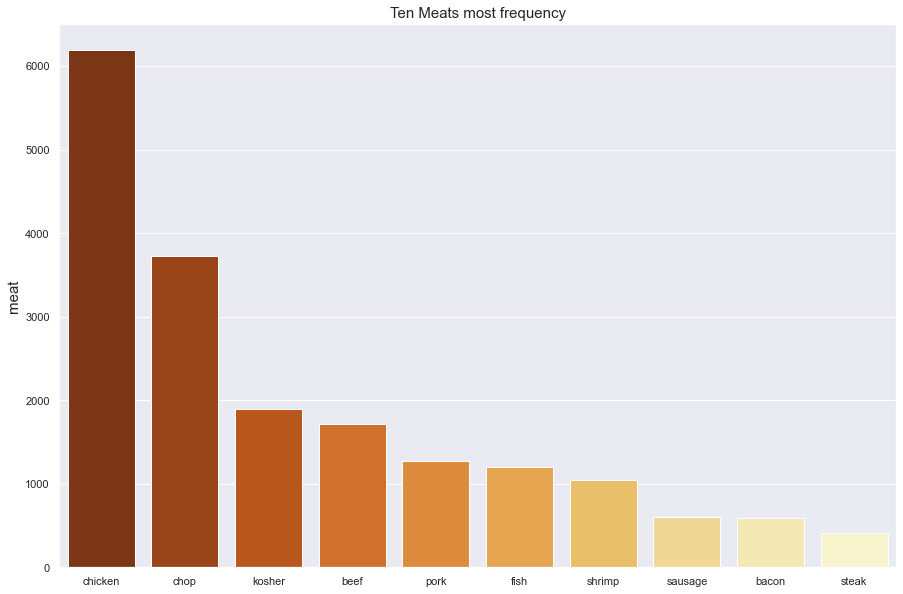

In [54]:
sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(15,10),
            'axes.labelsize': 15, 
            'font.size': 20, 
            'legend.fontsize': 12, 
            'axes.titlesize':15,
            'figure.facecolor': 'white',
            'font.family': ['sans-serif'],
            'legend.fancybox': True,
            'lines.color': 'C0',
            'xaxis.labellocation': 'center',
            'xtick.alignment': 'center',
            'legend.title_fontsize': 15,
            'legend.edgecolor': '0.9',
            'animation.ffmpeg_path': 'ffmpeg',
           })   
plt.title('Ten Meats most frequency')
sns.set_style("whitegrid")


sns_plot = sns.barplot(df_less['meat'].value_counts().index[1:11], df_less['meat'].value_counts()[1:11],palette='YlOrBr_r')

In [55]:
sns_plot.figure.savefig("Meats.png")

In [56]:
df_less['sugar'] = df_1['final'].apply(lambda x: pattern_searcher(search_str=x, search_list=pattern2))

In [57]:
nomeat = df_less[(df_less['meat'] == "No") & (df_less['sugar'] == "No")]
nomeat.reset_index(drop=True, inplace = True)
nomeat.head()

cuisine                                        ingredients  \
0        greek  ['romaine lettuce', 'black olives', 'grape tom...   
1  southern_us  ['plain flour', 'ground pepper', 'salt', 'toma...   
2     jamaican  ['plain flour', 'sugar', 'butter', 'eggs', 'fr...   
3         thai  ['pork loin', 'roasted peanuts', 'chopped cila...   
4      italian  ['ground black pepper', 'butter', 'sliced mush...   

                                     lemmatizer_text  \
0  romaine lettuce black olive grape tomato garli...   
1  plain flour ground pepper salt tomato ground b...   
2                     water vegetable oil wheat salt   
3  tumeric vegetable stock tomato garam masala na...   
4  low fat mayonnaise pepper salt baking potato e...   

                                               final  Len meat sugar  
0  romaine lettuce, black olive, grape tomato, ga...    9   No    No  
1  plain flour, ground pepper, salt, tomato, grou...   11   No    No  
2  plain flour, sugar, butter, egg, fresh ginger ...   12   No    No  
3  pork loin, roasted peanut, chopped cilantro fr...   12   No    No  
4  ground black pepper, butter, sliced mushroom, ...   11   No    No

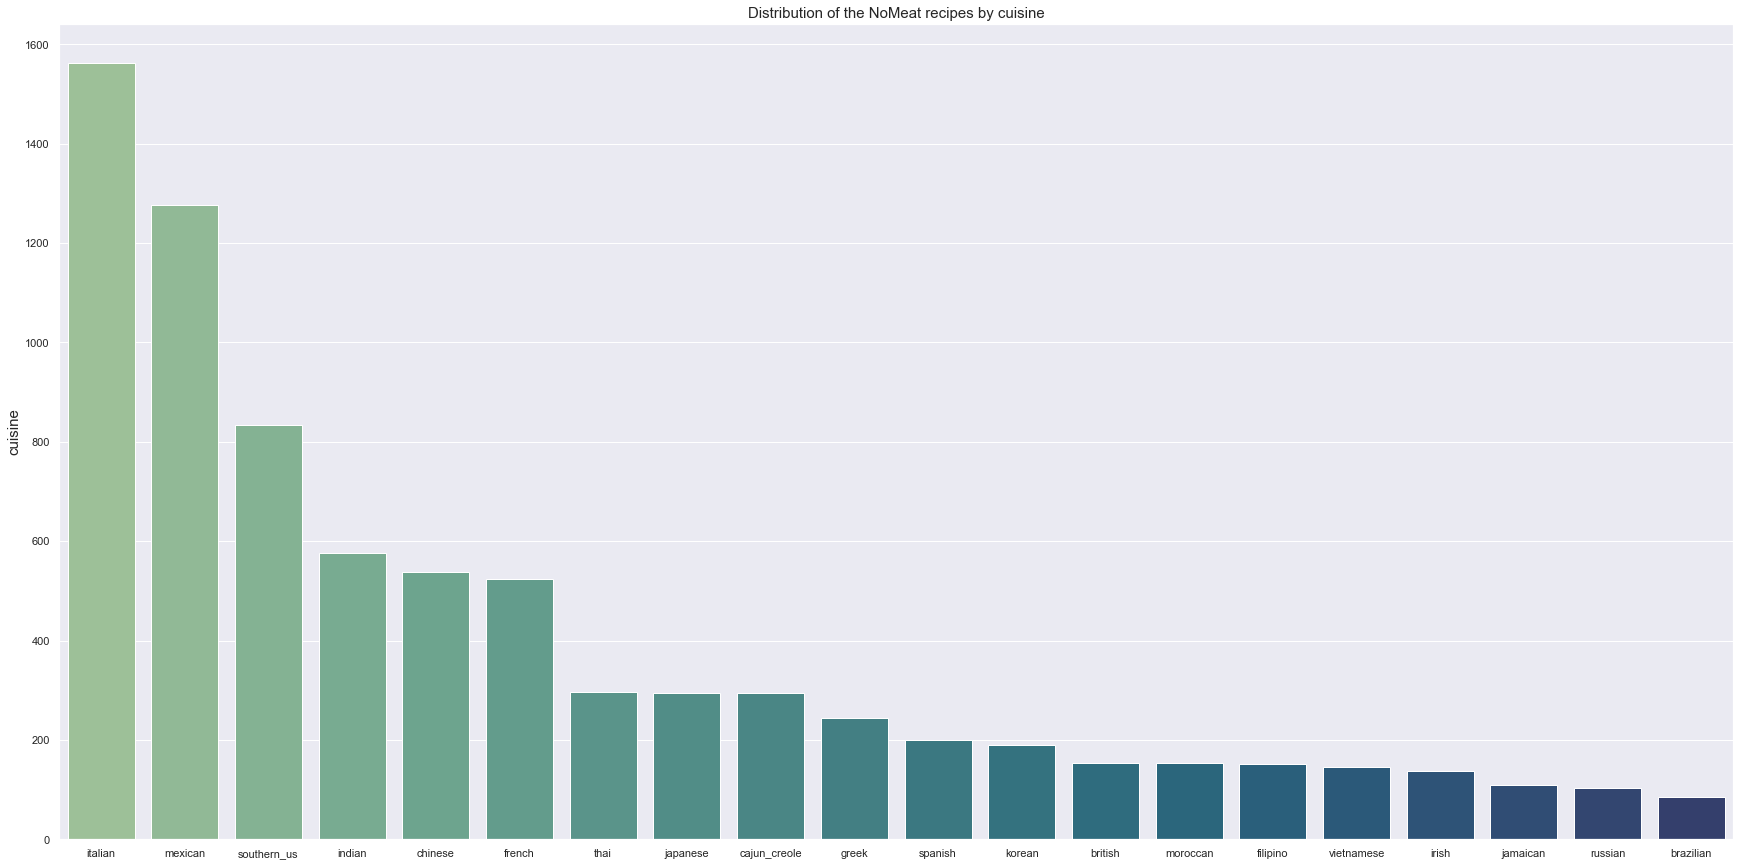

In [58]:
sns.set(rc={'figure.figsize':(30,15),
            'axes.labelsize': 15, 
            'font.size': 15, 
            'legend.fontsize': 12, 
            'axes.titlesize':15,
            'figure.facecolor': 'white',
            'font.family': ['sans-serif'],
            'legend.fancybox': True,
            'lines.color': 'C0',
            'xaxis.labellocation': 'center',
            'xtick.alignment': 'center',
            'legend.title_fontsize': 15,
            'legend.edgecolor': '0.9',
            'animation.ffmpeg_path': 'ffmpeg',
           })    
plt.title('Distribution of the NoMeat recipes by cuisine')

sns.set_style("whitegrid")

sns_plot= sns.barplot(nomeat['cuisine'].value_counts().index,
            nomeat['cuisine'].value_counts(),palette='crest', )


In [59]:
sns_plot.figure.savefig("NoMeats_distribution.png")

In [60]:
meat = df_less[df_less['meat'] != "No"]
meat.reset_index(drop=True, inplace = True)
meat.head(3)

cuisine                                        ingredients  \
0  filipino  ['eggs', 'pepper', 'salt', 'mayonaise', 'cooki...   
1   spanish  ['olive oil', 'salt', 'medium shrimp', 'pepper...   
2   mexican  ['olive oil', 'purple onion', 'fresh pineapple...   

                                     lemmatizer_text  \
0  egg pepper salt mayonaise cooking oil green ch...   
1  black pepper shallot cornflour cayenne pepper ...   
2  olive oil salt medium shrimp pepper garlic cho...   

                                               final  Len     meat sugar  
0  egg, pepper, salt, mayonaise, cooking oil, gre...   12  chicken    No  
1  olive oil, salt, medium shrimp, pepper, garlic...   13  chicken    No  
2  olive oil, purple onion, fresh pineapple, pork...   13   shrimp    No

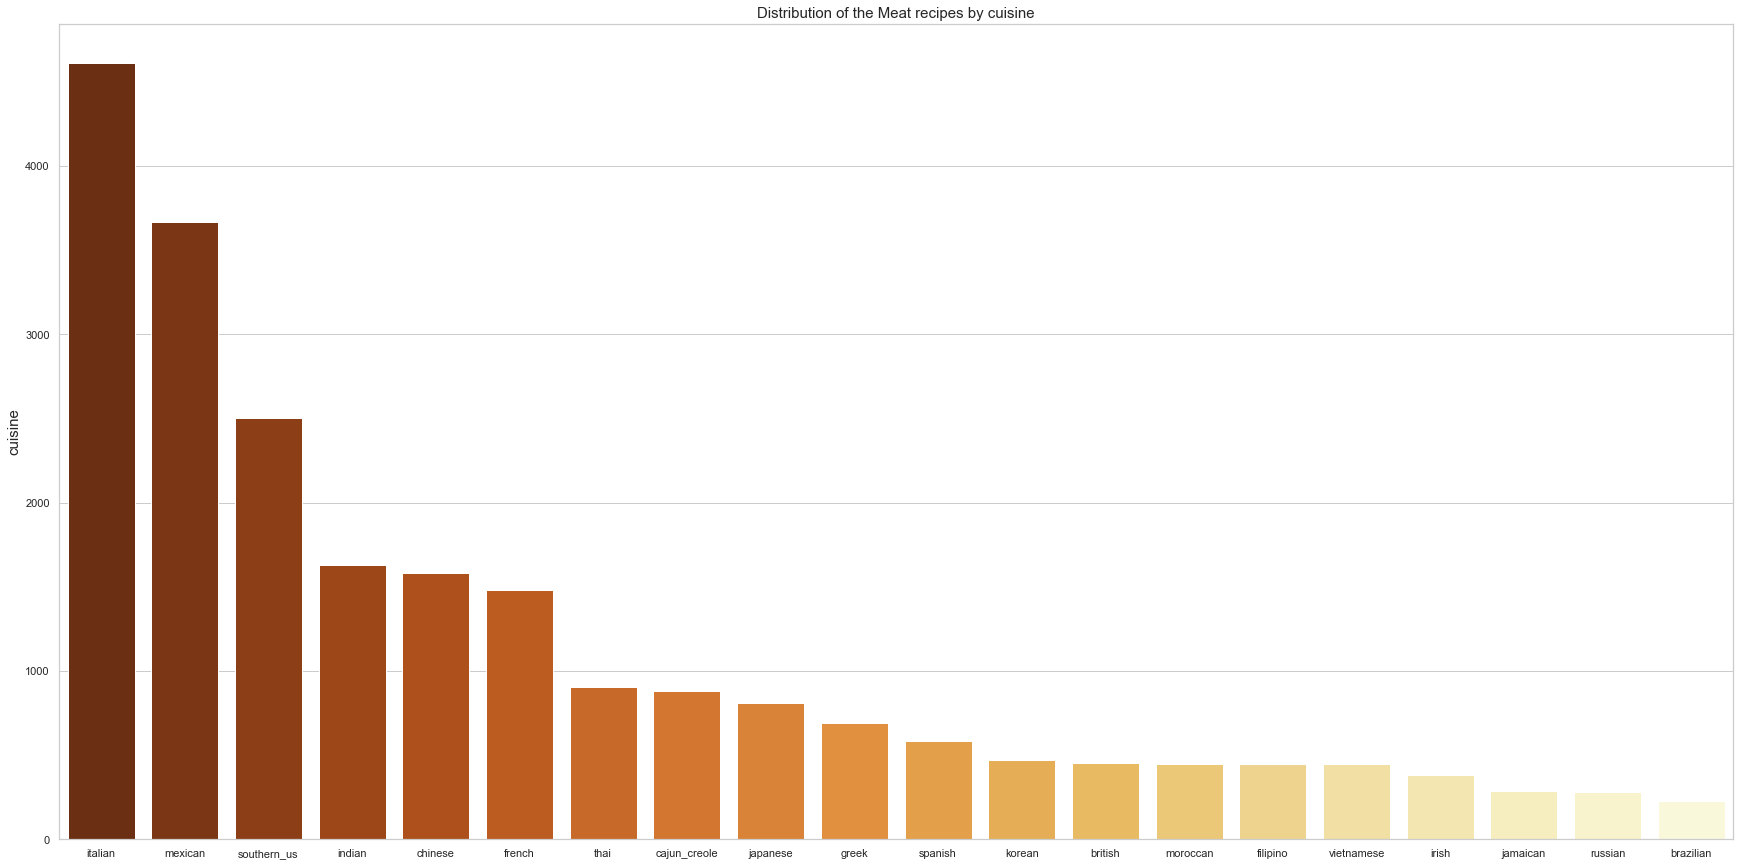

In [61]:
sns.set(rc={'figure.figsize':(30,15),
            'axes.labelsize': 15, 
            'font.size': 15, 
            'legend.fontsize': 12, 
            'axes.titlesize':15,
            'figure.facecolor': 'white',
            'font.family': ['sans-serif'],
            'legend.fancybox': True,
            'lines.color': 'C0',
            'xaxis.labellocation': 'center',
            'xtick.alignment': 'center',
            'legend.title_fontsize': 15,
            'legend.edgecolor': '0.9',
            'animation.ffmpeg_path': 'ffmpeg',
           })   

sns.set_style("whitegrid")

plt.title('Distribution of the Meat recipes by cuisine')

sns_plot= sns.barplot(meat['cuisine'].value_counts().index,
            meat['cuisine'].value_counts(),palette='YlOrBr_r')

In [62]:
sns_plot.figure.savefig("Meats_distribution.png")

In [63]:
sweet = df_less[(df_less['meat'] == "No") & (df_less['sugar'] != "No")]
sweet.reset_index(drop=True, inplace = True)
sweet

cuisine                                        ingredients  \
0          italian  ['sugar', 'pistachio nuts', 'white almond bark...   
1          italian  ['chopped tomatoes', 'fresh basil', 'garlic', ...   
2          mexican  ['roma tomatoes', 'kosher salt', 'purple onion...   
3          italian  ['Oscar Mayer Deli Fresh Smoked Ham', 'hoagie ...   
4      southern_us  ['large eggs', 'whipping cream', 'chicken brot...   
...            ...                                                ...   
5702       italian  ['milk', 'parmigiano reggiano cheese', 'freshl...   
5703       italian  ['spinach', 'purple onion', 'french bread', 'p...   
5704  cajun_creole  ['pepper', 'garlic', 'golden mushroom soup', '...   
5705        korean  ['red chili peppers', 'sea salt', 'onions', 'w...   
5706       italian  ['low-fat sour cream', 'grated parmesan cheese...   

                                        lemmatizer_text  \
0     plain flour sugar butter egg fresh ginger root...   
1     sugar pistachio nut white almond bark flour va...   
2     greek yogurt lemon curd confectioner sugar ras...   
3     olive oil onion crushed garlic dried oregano g...   
4     egg mandarin orange water orange liqueur yello...   
...                                                 ...   
5702  sesame seed beer vegetable oil fresh lime juic...   
5703  lime juice purpose flour fresh green bean oil ...   
5704  fresh lima bean corn kernel ground mustard whi...   
5705  vegetable oil purpose flour shortening vanilla...   
5706  reduced sodium soy sauce water snow pea shoot ...   

                                                  final  Len meat  sugar  
0     sugar, pistachio nut, white almond bark, flour...   10   No  sugar  
1     chopped tomato, fresh basil, garlic, extra vir...    6   No  sugar  
2     rom tomato, kosher salt, purple onion, jalapen...    6   No  sugar  
3     oscar mayer deli fresh smoked ham, hoagie roll...    8   No  sugar  
4     large egg, whipping cream, chicken broth, grou...   10   No  sugar  
...                                                 ...  ...  ...    ...  
5702  milk, parmigiano reggiano cheese, freshly grou...   11   No  sugar  
5703  spinach, purple onion, french bread, plum toma...    8   No  sugar  
5704  pepper, garlic, golden mushroom soup, cajun se...   11   No  sugar  
5705  red chili pepper, sea salt, onion, water, chil...   10   No  sugar  
5706  low fat sour cream, grated parmesan cheese, sa...   13   No  sugar  

[5707 rows x 7 columns]

# Tagging the ingredients

In [64]:
import nltk
# nltk.download('averaged_perceptron_tagger')
def preprocess(sent):
    sent = nltk.word_tokenize(sent)
    sent = nltk.pos_tag(sent)
    return sent



In [65]:
# Add a new column with the preprocess
df_less["prepros"] = df_less["final"].apply(lambda x: preprocess(x))


In [66]:
# Create a list of the adjectives
jj = []
for a in df_less["prepros"]:
    for row in a:
        if 'JJ' in row:
            jj.append(row[0])
jj

['black',
 'garlic',
 'purple',
 'garbanzo',
 'feta',
 'flour',
 'black',
 'green',
 'yellow',
 'vegetable',
 'green',
 'garlic',
 'yellow',
 'flour',
 'fresh',
 'olive',
 'garlic',
 'flat',
 'white',
 'white',
 'olive',
 'olive',
 'fresh',
 'black',
 'fresh',
 'garlic',
 'extra',
 'olive',
 'flat',
 'sweet',
 'olive',
 'sharp',
 'swiss',
 'canola',
 'black',
 'low',
 'fresh',
 'dry',
 'green',
 'white',
 'sesame',
 'canola',
 'garlic',
 'red',
 'italian',
 'hot',
 'red',
 'extra',
 'olive',
 'fresh',
 'garlic',
 'fine',
 'flat',
 'fresh',
 'black',
 'garlic',
 'plum',
 'lime',
 'flank',
 'black',
 'olive',
 'red',
 'fresh',
 'fat',
 'free',
 'fresh',
 'cheese',
 'ground',
 'black',
 'fat',
 'free',
 'vegetable',
 'red',
 'red',
 'sweet',
 'vegetable',
 'red',
 'yellow',
 'garlic',
 'green',
 'fresh',
 'creamy',
 'fresh',
 'thai',
 'purple',
 'low',
 'red',
 'yellow',
 'extra',
 'arrowroot',
 'fresh',
 'sesame',
 'red',
 'flat',
 'olive',
 'red',
 'olive',
 'lemon',
 'lo',
 'light',
 '

In [67]:
# Create a list of the noun

nn = []
for a in df_less["prepros"]:
    for row in a:
        if 'NN' in row:
            nn.append(row[0])
nn

['romaine',
 'lettuce',
 'olive',
 'grape',
 'tomato',
 'pepper',
 'onion',
 'bean',
 'cheese',
 'ground',
 'pepper',
 'salt',
 'tomato',
 'ground',
 'pepper',
 'thyme',
 'egg',
 'tomato',
 'corn',
 'meal',
 'milk',
 'oil',
 'egg',
 'pepper',
 'salt',
 'mayonaise',
 'oil',
 'chicken',
 'breast',
 'powder',
 'onion',
 'soy',
 'sauce',
 'butter',
 'liver',
 'sugar',
 'butter',
 'egg',
 'ginger',
 'root',
 'salt',
 'ground',
 'cinnamon',
 'milk',
 'vanilla',
 'extract',
 'ground',
 'ginger',
 'sugar',
 'powder',
 'oil',
 'salt',
 'medium',
 'shrimp',
 'pepper',
 'cilantro',
 'jalapeno',
 'leaf',
 'parsley',
 'skirt',
 'steak',
 'vinegar',
 'sea',
 'salt',
 'bay',
 'leaf',
 'chorizo',
 'sausage',
 'sugar',
 'pistachio',
 'nut',
 'almond',
 'bark',
 'flour',
 'vanilla',
 'extract',
 'oil',
 'almond',
 'extract',
 'egg',
 'powder',
 'cranberry',
 'oil',
 'purple',
 'onion',
 'pineapple',
 'pork',
 'poblano',
 'pepper',
 'corn',
 'tortilla',
 'cheddar',
 'cheese',
 'ground',
 'pepper',
 'salt

In [68]:
vocabjj = Counter(jj)
vocabnn = Counter(nn)

In [69]:
vocabjj.most_common(15)

[('fresh', 14768),
 ('garlic', 14330),
 ('olive', 10885),
 ('black', 9773),
 ('red', 8294),
 ('green', 7868),
 ('white', 7272),
 ('vegetable', 5254),
 ('large', 5120),
 ('extra', 2886),
 ('dry', 2873),
 ('unsalted', 2724),
 ('lemon', 2407),
 ('parmesan', 2284),
 ('low', 2098)]

In [70]:
vocabnn.most_common(15)

[('pepper', 24059),
 ('salt', 22588),
 ('oil', 21541),
 ('onion', 17554),
 ('ground', 16141),
 ('sauce', 12006),
 ('sugar', 11482),
 ('cheese', 10566),
 ('tomato', 9890),
 ('water', 8781),
 ('egg', 8526),
 ('butter', 8043),
 ('powder', 7345),
 ('clove', 7342),
 ('chicken', 6853)]

In [71]:
df_less

cuisine                                        ingredients  \
0            greek  ['romaine lettuce', 'black olives', 'grape tom...   
1      southern_us  ['plain flour', 'ground pepper', 'salt', 'toma...   
2         filipino  ['eggs', 'pepper', 'salt', 'mayonaise', 'cooki...   
3         jamaican  ['plain flour', 'sugar', 'butter', 'eggs', 'fr...   
4          spanish  ['olive oil', 'salt', 'medium shrimp', 'pepper...   
...            ...                                                ...   
36371      mexican  ['shredded cheddar cheese', 'crushed cheese cr...   
36372        irish  ['light brown sugar', 'granulated sugar', 'but...   
36373      italian  ['KRAFT Zesty Italian Dressing', 'purple onion...   
36374        irish  ['eggs', 'citrus fruit', 'raisins', 'sourdough...   
36375      mexican  ['green chile', 'jalapeno chilies', 'onions', ...   

                                         lemmatizer_text  \
0      romaine lettuce black olive grape tomato garli...   
1      plain flour ground pepper salt tomato ground b...   
2      egg pepper salt mayonaise cooking oil green ch...   
3                         water vegetable oil wheat salt   
4      black pepper shallot cornflour cayenne pepper ...   
...                                                  ...   
36371  spinach purple onion mushroom coconut oil coco...   
36372  fresh curry leaf ground red pepper dried red c...   
36373  kosher salt ancho chile pepper garlic clove gr...   
36374  large egg yolk gochujang base toasted sesame s...   
36375  pepper rice vinegar flat leaf parsley garlic d...   

                                                   final  Len     meat  sugar  \
0      romaine lettuce, black olive, grape tomato, ga...    9       No     No   
1      plain flour, ground pepper, salt, tomato, grou...   11       No     No   
2      egg, pepper, salt, mayonaise, cooking oil, gre...   12  chicken     No   
3      plain flour, sugar, butter, egg, fresh ginger ...   12       No     No   
4      olive oil, salt, medium shrimp, pepper, garlic...   13  chicken     No   
...                                                  ...  ...      ...    ...   
36371  shredded cheddar cheese, crushed cheese cracke...   10       No     No   
36372  light brown sugar, granulated sugar, butter, w...   12       No     No   
36373  kraft zesty italian dressing, purple onion, br...    7   kosher  sugar   
36374  egg, citrus fruit, raisin, sourdough starter, ...   12   kosher     No   
36375  green chile, jalapeno chilies, onion, ground b...   12       No     No   

                                                 prepros  
0      [(romaine, NN), (lettuce, NN), (,, ,), (black,...  
1      [(plain, RB), (flour, JJ), (,, ,), (ground, NN...  
2      [(egg, NN), (,, ,), (pepper, NN), (,, ,), (sal...  
3      [(plain, RB), (flour, JJ), (,, ,), (sugar, NN)...  
4      [(olive, JJ), (oil, NN), (,, ,), (salt, NN), (...  
...                                                  ...  
36371  [(shredded, VBN), (cheddar, NN), (cheese, NN),...  
36372  [(light, JJ), (brown, NN), (sugar, NN), (,, ,)...  
36373  [(kraft, NN), (zesty, NN), (italian, JJ), (dre...  
36374  [(egg, NN), (,, ,), (citrus, NN), (fruit, NN),...  
36375  [(green, JJ), (chile, NN), (,, ,), (jalapeno, ...  

[36376 rows x 8 columns]

# Searching for Brands

In [72]:
import spacy
from spacy import displacy
from collections import Counter

## Spanish corpus (https://spacy.io/models/es#es_core_news_md)
# python -m spacy download es
import es_core_news_sm
nlp_sp = es_core_news_sm.load()
nlp_sp

## English corpus
#python -m spacy download en
import en_core_web_sm
nlp = en_core_web_sm.load()
nlp

In [73]:
df_less["prepros2"] = df_less["final"].apply(lambda x: nlp(x))

In [74]:
# Create a list of the brands
a=[]
for row in df_less["final"]:
    doc = nlp(row)
    a += [(X.text, X.label_) for X in doc.ents]

In [75]:
a

[('romaine lettuce', 'PERSON'),
 ('grape tomato', 'PERSON'),
 ('green tomato', 'PERSON'),
 ('cilantro', 'GPE'),
 ('flat leaf parsley', 'ORG'),
 ('skirt steak', 'ORG'),
 ('white vinegar', 'ORG'),
 ('sea salt', 'GPE'),
 ('bay leaf', 'ORG'),
 ('pistachio nut', 'PERSON'),
 ('white almond bark', 'ORG'),
 ('flour', 'PERSON'),
 ('jalapeno chilies', 'PERSON'),
 ('cilantro', 'GPE'),
 ('kosher salt', 'ORG'),
 ('swiss', 'NORP'),
 ('canola', 'PRODUCT'),
 ('fresh ginger', 'PERSON'),
 ('green bean', 'ORG'),
 ('canola', 'PRODUCT'),
 ('turkey', 'GPE'),
 ('italian', 'NORP'),
 ('garlic clove', 'PERSON'),
 ('chipotle chile', 'PERSON'),
 ('ground cinnamon', 'PERSON'),
 ('cilantro', 'GPE'),
 ('chili', 'GPE'),
 ('kosher salt', 'ORG'),
 ('plum tomato', 'PERSON'),
 ('avocado', 'GPE'),
 ('flank steak', 'GPE'),
 ('salt', 'ORG'),
 ('ground cumin', 'PERSON'),
 ('parmesan cheese', 'ORG'),
 ('fat free le sodium chicken', 'ORG'),
 ('gruyere cheese', 'PERSON'),
 ('bacon slice', 'GPE'),
 ('gnocchi', 'GPE'),
 ('tomato'

In [76]:
print([(X) for X in a if 'ORG' in X])

[('flat leaf parsley', 'ORG'), ('skirt steak', 'ORG'), ('white vinegar', 'ORG'), ('bay leaf', 'ORG'), ('white almond bark', 'ORG'), ('kosher salt', 'ORG'), ('green bean', 'ORG'), ('kosher salt', 'ORG'), ('salt', 'ORG'), ('parmesan cheese', 'ORG'), ('fat free le sodium chicken', 'ORG'), ('tomato', 'ORG'), ('red bell pepper', 'ORG'), ('broccoli', 'ORG'), ('orange bell pepper', 'ORG'), ('flat leaf parsley', 'ORG'), ('chile pepper', 'ORG'), ('red chili pepper', 'ORG'), ('parmesan cheese', 'ORG'), ('parmesan cheese', 'ORG'), ('red bell', 'ORG'), ('andouille sausage', 'ORG'), ('chili powder', 'ORG'), ('garlic powder', 'ORG'), ('lime wedge', 'ORG'), ('chile powder', 'ORG'), ('tomato', 'ORG'), ('chili powder', 'ORG'), ('collard green', 'ORG'), ('apple cider', 'ORG'), ('chile powder', 'ORG'), ('bay leaf', 'ORG'), ('ice cube', 'ORG'), ('white rum', 'ORG'), ('tomato', 'ORG'), ('white vinegar', 'ORG'), ('avocado', 'ORG'), ('egg', 'ORG'), ('white vinegar', 'ORG'), ('bay leaf', 'ORG'), ('basil', 'OR

# Vectorizer and Clustering

## Clustering without a Cuisine Type

In [77]:
count_vectorizer = CountVectorizer()
train_vectors = count_vectorizer.fit_transform(df_less['final'])

train_vectors

a = train_vectors.todense()

unidades_datos = np.array(a)
unidades_datos


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [78]:
# I transform the array into a DF 
new_df = pd.DataFrame(unidades_datos)
new_df

0     1     2     3     4     5     6     7     8     9     ...  2711  \
0         0     0     0     0     0     0     0     0     0     0  ...     0   
1         0     0     0     0     0     0     0     0     0     0  ...     0   
2         0     0     0     0     0     0     0     0     0     0  ...     0   
3         0     0     0     0     0     0     0     0     0     0  ...     0   
4         0     0     0     0     0     0     0     0     0     0  ...     0   
...     ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
36371     0     0     0     0     0     0     0     0     0     0  ...     0   
36372     0     0     0     0     0     0     0     0     0     0  ...     0   
36373     0     0     0     0     0     0     0     0     0     0  ...     0   
36374     0     0     0     0     0     0     0     0     0     0  ...     0   
36375     0     0     0     0     0     0     0     0     0     0  ...     0   

       2712  2713  2714  2715  2716  2717  2718  2719  2720  
0         0     0     0     0     0     0     0     0     0  
1         0     0     0     0     0     0     0     0     0  
2         0     0     0     0     0     0     0     0     0  
3         0     0     0     0     0     0     0     0     0  
4         0     0     0     0     0     0     0     0     0  
...     ...   ...   ...   ...   ...   ...   ...   ...   ...  
36371     0     0     0     0     0     0     0     0     0  
36372     0     0     0     0     0     0     0     0     0  
36373     0     0     0     0     0     1     0     0     0  
36374     0     0     0     0     0     0     0     0     0  
36375     0     0     0     0     0     0     0     0     0  

[36376 rows x 2721 columns]

In [79]:
from sklearn.cluster import KMeans
inertia =[]

In [80]:
###Static code to get max no of clusters

for i in range(1,10):
    kmeans = KMeans(n_clusters= i,random_state = 43)
    kmeans.fit(new_df)
    inertia.append(kmeans.inertia_)

In [81]:
from kneed import KneeLocator
kl = KneeLocator(range(1, 10), inertia, curve="convex", direction="decreasing")
print('The elbow point of your model is:', kl.elbow)

The elbow point of your model is: 4


In [82]:
kmeansmodel = KMeans(n_clusters= 4, random_state=0)
y_kmeans= kmeansmodel.fit_predict(new_df)

In [83]:
# Create a new column with the cluster id
df_less['cluster_id'] = y_kmeans
df_less

cuisine                                        ingredients  \
0            greek  ['romaine lettuce', 'black olives', 'grape tom...   
1      southern_us  ['plain flour', 'ground pepper', 'salt', 'toma...   
2         filipino  ['eggs', 'pepper', 'salt', 'mayonaise', 'cooki...   
3         jamaican  ['plain flour', 'sugar', 'butter', 'eggs', 'fr...   
4          spanish  ['olive oil', 'salt', 'medium shrimp', 'pepper...   
...            ...                                                ...   
36371      mexican  ['shredded cheddar cheese', 'crushed cheese cr...   
36372        irish  ['light brown sugar', 'granulated sugar', 'but...   
36373      italian  ['KRAFT Zesty Italian Dressing', 'purple onion...   
36374        irish  ['eggs', 'citrus fruit', 'raisins', 'sourdough...   
36375      mexican  ['green chile', 'jalapeno chilies', 'onions', ...   

                                         lemmatizer_text  \
0      romaine lettuce black olive grape tomato garli...   
1      plain flour ground pepper salt tomato ground b...   
2      egg pepper salt mayonaise cooking oil green ch...   
3                         water vegetable oil wheat salt   
4      black pepper shallot cornflour cayenne pepper ...   
...                                                  ...   
36371  spinach purple onion mushroom coconut oil coco...   
36372  fresh curry leaf ground red pepper dried red c...   
36373  kosher salt ancho chile pepper garlic clove gr...   
36374  large egg yolk gochujang base toasted sesame s...   
36375  pepper rice vinegar flat leaf parsley garlic d...   

                                                   final  Len     meat  sugar  \
0      romaine lettuce, black olive, grape tomato, ga...    9       No     No   
1      plain flour, ground pepper, salt, tomato, grou...   11       No     No   
2      egg, pepper, salt, mayonaise, cooking oil, gre...   12  chicken     No   
3      plain flour, sugar, butter, egg, fresh ginger ...   12       No     No   
4      olive oil, salt, medium shrimp, pepper, garlic...   13  chicken     No   
...                                                  ...  ...      ...    ...   
36371  shredded cheddar cheese, crushed cheese cracke...   10       No     No   
36372  light brown sugar, granulated sugar, butter, w...   12       No     No   
36373  kraft zesty italian dressing, purple onion, br...    7   kosher  sugar   
36374  egg, citrus fruit, raisin, sourdough starter, ...   12   kosher     No   
36375  green chile, jalapeno chilies, onion, ground b...   12       No     No   

                                                 prepros  \
0      [(romaine, NN), (lettuce, NN), (,, ,), (black,...   
1      [(plain, RB), (flour, JJ), (,, ,), (ground, NN...   
2      [(egg, NN), (,, ,), (pepper, NN), (,, ,), (sal...   
3      [(plain, RB), (flour, JJ), (,, ,), (sugar, NN)...   
4      [(olive, JJ), (oil, NN), (,, ,), (salt, NN), (...   
...                                                  ...   
36371  [(shredded, VBN), (cheddar, NN), (cheese, NN),...   
36372  [(light, JJ), (brown, NN), (sugar, NN), (,, ,)...   
36373  [(kraft, NN), (zesty, NN), (italian, JJ), (dre...   
36374  [(egg, NN), (,, ,), (citrus, NN), (fruit, NN),...   
36375  [(green, JJ), (chile, NN), (,, ,), (jalapeno, ...   

                                                prepros2  cluster_id  
0      (romaine, lettuce, ,, black, olive, ,, grape, ...           3  
1      (plain, flour, ,, ground, pepper, ,, salt, ,, ...           1  
2      (egg, ,, pepper, ,, salt, ,, mayonaise, ,, coo...           0  
3      (plain, flour, ,, sugar, ,, butter, ,, egg, ,,...           2  
4      (olive, oil, ,, salt, ,, medium, shrimp, ,, pe...           1  
...                                                  ...         ...  
36371  (shredded, cheddar, cheese, ,, crushed, cheese...           3  
36372  (light, brown, sugar, ,, granulated, sugar, ,,...           2  
36373  (kraft, zesty, italian, dressing, ,, purple, o...           3  
36374  (e

In [84]:
df_less['cluster_id'].value_counts()

3    15340
1    10340
2     5410
0     5286
Name: cluster_id, dtype: int64

In [85]:
# Save as a new Data
df_less.to_csv('../dataset/01-Data_Clean.csv')

In [86]:
# Check the cluster 2
c2= df_less[df_less['cluster_id'] == 2]
c2['cuisine'].value_counts()

southern_us     1662
french           832
italian          724
british          386
mexican          287
irish            258
indian           187
russian          185
cajun_creole     140
japanese         114
filipino         102
spanish           95
chinese           94
greek             93
brazilian         68
jamaican          63
thai              45
moroccan          37
vietnamese        20
korean            18
Name: cuisine, dtype: int64

In [87]:
c2.groupby(['cuisine'])["Len"].describe()

count       mean       std  min   25%   50%    75%   max
cuisine                                                                
brazilian       68.0   7.514706  2.756228  5.0  6.00   6.0   9.00  19.0
british        386.0   9.484456  3.234717  5.0  7.00   9.0  11.75  19.0
cajun_creole   140.0  10.714286  3.456379  5.0  8.00  10.0  13.00  19.0
chinese         94.0   8.702128  2.801036  5.0  7.00   9.0  10.00  19.0
filipino       102.0   7.490196  2.201463  5.0  6.00   7.0   9.00  17.0
french         832.0   9.199519  2.924826  5.0  7.00   9.0  11.00  19.0
greek           93.0   9.677419  2.579861  5.0  8.00  10.0  11.00  16.0
indian         187.0   8.566845  2.629357  5.0  7.00   8.0  10.00  18.0
irish          258.0   9.341085  2.916466  5.0  7.00   9.0  12.00  18.0
italian        724.0   9.435083  2.844992  5.0  7.00   9.0  11.00  18.0
jamaican        63.0  10.047619  3.585043  5.0  8.00   9.0  12.00  19.0
japanese       114.0   8.912281  3.202768  5.0  7.00   8.0  11.00  19.0
korean          18.0   7.722222  1.637989  5.0  6.25   8.0   9.00  10.0
mexican        287.0   8.975610  2.979434  5.0  7.00   9.0  11.00  18.0
moroccan        37.0   8.972973  2.619229  5.0  7.00   8.0  11.00  15.0
russian        185.0  10.070270  3.139931  5.0  8.00  10.0  12.00  19.0
southern_us   1662.0   9.731047  2.954275  5.0  8.00   9.0  12.00  19.0
spanish         95.0   8.610526  2.577706  5.0  7.00   8.0   9.00  17.0
thai            45.0   7.244444  1.798428  5.0  6.00   7.0   8.00  13.0
vietnamese      20.0   8.700000  2.556725  5.0  7.00   8.0  10.25  14.0

In [88]:
c1= df_less[df_less['cluster_id'] == 1]
c2= df_less[df_less['cluster_id'] == 2]
c3= df_less[df_less['cluster_id'] == 3]
c0= df_less[df_less['cluster_id'] == 0]

In [89]:
from wordcloud import WordCloud, STOPWORDS
# wrap the plotting in a function for easier access
def plot_wordcloud(wordcloud, language):
    plt.figure(figsize=(12, 10))
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis("off")
    plt.title(language + 'Cluster', fontsize=18, fontweight='bold')
    plt.show()

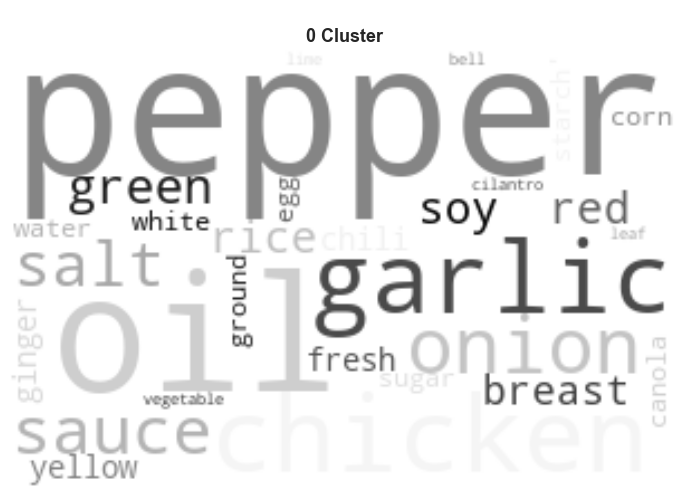

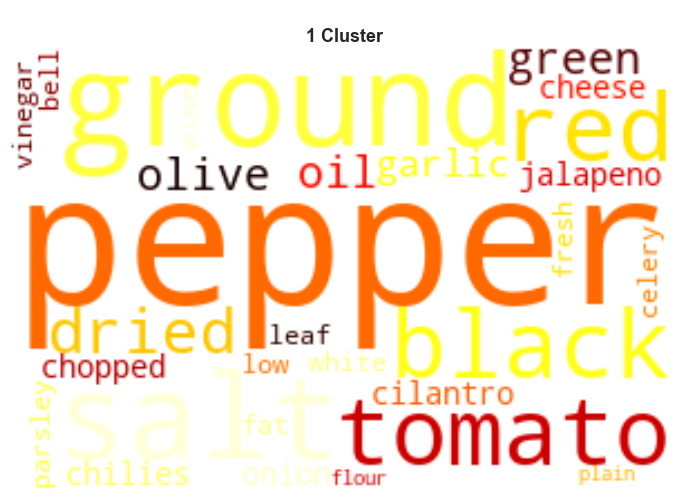

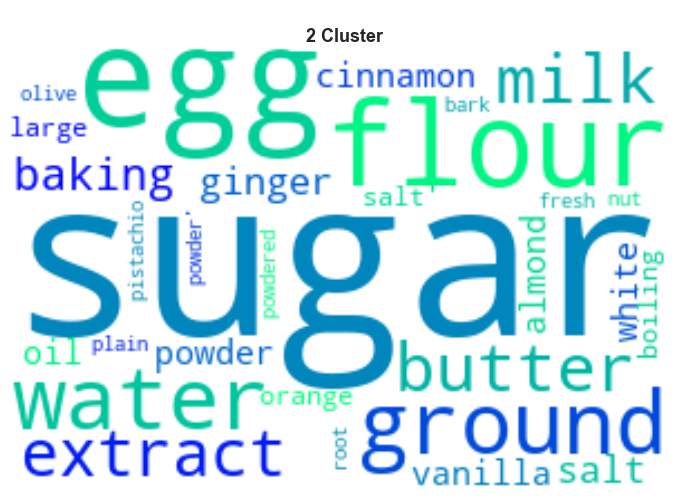

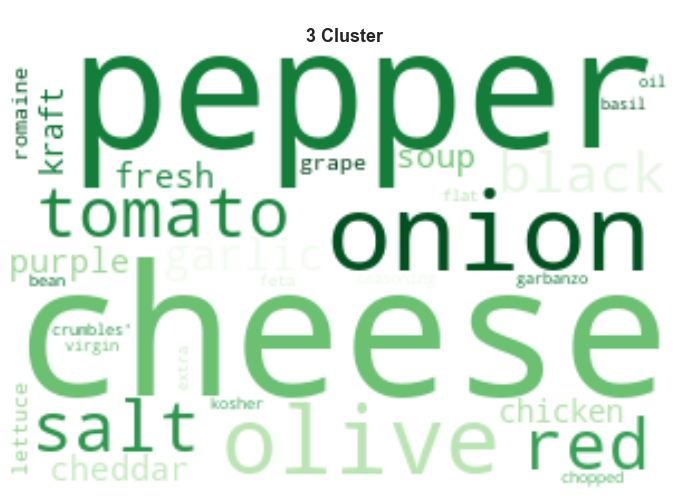

In [90]:
wordcloud = WordCloud(max_font_size=200, max_words=30, background_color="white",width= 300, height = 200,
                      stopwords = stopwords.words('english')).generate(str(c0.final.values))
plot_wordcloud(wordcloud.recolor( colormap= 'gray' , random_state=17), '\n 0 ')
wordcloud.to_file('Cluster0.png')

wordcloud = WordCloud(max_font_size=200, max_words=30, background_color="white", width= 300, height = 200,
                      stopwords = stopwords.words('english')).generate(str(c1.final.values))
plot_wordcloud(wordcloud.recolor( colormap= 'hot' , random_state=17), '\n 1 ')
wordcloud.to_file('Cluster1.png')

wordcloud = WordCloud(max_font_size=200, max_words=30, background_color="white",width= 300, height = 200,
                      stopwords = stopwords.words('english')).generate(str(c2.final.values))

plot_wordcloud(wordcloud.recolor( colormap= 'winter' , random_state=17), '\n 2 ')
wordcloud.to_file('Cluster2.png')


wordcloud = WordCloud(max_font_size=200, max_words=30, background_color="white",width= 300, height = 200,
                      stopwords = stopwords.words('english')).generate(str(c3.final.values))
plot_wordcloud(wordcloud.recolor( colormap= 'Greens' , random_state=17), '\n 3 ')
wordcloud.to_file('Cluster3.png')


In [91]:
c3.cuisine.value_counts()

italian         3723
mexican         3606
southern_us     1502
indian          1350
french           980
greek            487
cajun_creole     451
japanese         449
spanish          371
thai             337
irish            279
chinese          278
british          255
filipino         205
moroccan         193
russian          187
vietnamese       185
brazilian        174
korean           168
jamaican         160
Name: cuisine, dtype: int64

In [92]:
c3.loc[c3.cuisine == 'italian', :].reset_index(drop=True).loc[0,"ingredients"]


"['chopped tomatoes', 'fresh basil', 'garlic', 'extra-virgin olive oil', 'kosher salt', 'flat leaf parsley']"

In [93]:
c1.cuisine.value_counts()

italian         2855
mexican         1897
indian          1071
cajun_creole     763
southern_us      734
french           570
greek            531
moroccan         484
spanish          444
jamaican         210
brazilian        127
thai             126
filipino          97
british           84
irish             77
russian           73
chinese           70
japanese          57
vietnamese        53
korean            17
Name: cuisine, dtype: int64

In [94]:
c1.loc[c1.cuisine == 'italian', :].reset_index(drop=True).loc[55,"ingredients"]

"['parmigiano-reggiano cheese', 'worcestershire sauce', 'garlic cloves', 'water', 'salt', 'fresh mint', 'baguette', 'extra-virgin olive oil', 'fresh lemon juice', 'eggs', 'ground black pepper', 'anchovy fillets', 'arugula']"

In [95]:
c1.loc[c1.cuisine == 'mexican', :].reset_index(drop=True).loc[0,"ingredients"]

"['olive oil', 'purple onion', 'fresh pineapple', 'pork', 'poblano peppers', 'corn tortillas', 'cheddar cheese', 'ground black pepper', 'salt', 'iceberg lettuce', 'lime', 'jalapeno chilies', 'chopped cilantro fresh']"

In [96]:
c0.loc[c0.cuisine == 'mexican', :].reset_index(drop=True).loc[0,"ingredients"]

"['cooked chicken', 'enchilada sauce', 'sliced green onions', 'picante sauce', 'green pepper', 'corn tortillas', 'canned black beans', 'shredded lettuce', 'sour cream', 'shredded cheddar cheese', 'garlic cloves', 'canola oil']"

## Clustering with cuisine

In [97]:
from sklearn.preprocessing import LabelEncoder
# Step 1. Instantiate the model (label encoding)
lb_make = LabelEncoder() 

# Step 2. Fit the variable to the instatiated model
new_df['Country'] = lb_make.fit_transform(df_less['cuisine'])

new_df['Len'] = df_less['Len']

In [98]:
new_df

0  1  2  3  4  5  6  7  8  9  ...  2713  2714  2715  2716  2717  2718  \
0      0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
1      0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
2      0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
3      0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
4      0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
...   .. .. .. .. .. .. .. .. .. ..  ...   ...   ...   ...   ...   ...   ...   
36371  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
36372  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
36373  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     1     0   
36374  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
36375  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   

       2719  2720  Country  Len  
0         0     0        6    9  
1         0     0       16   11  
2         0     0        4   12  
3         0     0       10   12  
4         0     0       17   13  
...     ...   ...      ...  ...  
36371     0     0       13   10  
36372     0     0        8   12  
36373     0     0        9    7  
36374     0     0        8   12  
36375     0     0       13   12  

[36376 rows x 2723 columns]

In [99]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36376 entries, 0 to 36375
Columns: 2723 entries, 0 to Len
dtypes: int32(1), int64(2722)
memory usage: 755.6 MB


In [100]:
from sklearn import preprocessing 

X = new_df

scaler = preprocessing.MinMaxScaler()
scaler

df_sc = scaler.fit_transform(X)
df_sc

array([[0.        , 0.        , 0.        , ..., 0.        , 0.31578947,
        0.28571429],
       [0.        , 0.        , 0.        , ..., 0.        , 0.84210526,
        0.42857143],
       [0.        , 0.        , 0.        , ..., 0.        , 0.21052632,
        0.5       ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.47368421,
        0.14285714],
       [0.        , 0.        , 0.        , ..., 0.        , 0.42105263,
        0.5       ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.68421053,
        0.5       ]])

In [101]:
from sklearn.cluster import KMeans
inertia =[]

###Static code to get max no of clusters

for i in range(1,10):
    kmeans = KMeans(n_clusters= i,random_state = 43)
    kmeans.fit(new_df)
    inertia.append(kmeans.inertia_)

In [102]:
df_sc = pd.DataFrame(df_sc, columns = X.columns) 

In [103]:
from kneed import KneeLocator
kl = KneeLocator(range(1, 10), inertia, curve="convex", direction="decreasing")
print('The elbow point of your model is:', kl.elbow)

The elbow point of your model is: 3


In [104]:
kmeansmodel = KMeans(n_clusters= 3, random_state=0)
y_kmeans= kmeansmodel.fit_predict(df_sc)

In [105]:
df_less['cluster_id2'] = y_kmeans
df_less

cuisine                                        ingredients  \
0            greek  ['romaine lettuce', 'black olives', 'grape tom...   
1      southern_us  ['plain flour', 'ground pepper', 'salt', 'toma...   
2         filipino  ['eggs', 'pepper', 'salt', 'mayonaise', 'cooki...   
3         jamaican  ['plain flour', 'sugar', 'butter', 'eggs', 'fr...   
4          spanish  ['olive oil', 'salt', 'medium shrimp', 'pepper...   
...            ...                                                ...   
36371      mexican  ['shredded cheddar cheese', 'crushed cheese cr...   
36372        irish  ['light brown sugar', 'granulated sugar', 'but...   
36373      italian  ['KRAFT Zesty Italian Dressing', 'purple onion...   
36374        irish  ['eggs', 'citrus fruit', 'raisins', 'sourdough...   
36375      mexican  ['green chile', 'jalapeno chilies', 'onions', ...   

                                         lemmatizer_text  \
0      romaine lettuce black olive grape tomato garli...   
1      plain flour ground pepper salt tomato ground b...   
2      egg pepper salt mayonaise cooking oil green ch...   
3                         water vegetable oil wheat salt   
4      black pepper shallot cornflour cayenne pepper ...   
...                                                  ...   
36371  spinach purple onion mushroom coconut oil coco...   
36372  fresh curry leaf ground red pepper dried red c...   
36373  kosher salt ancho chile pepper garlic clove gr...   
36374  large egg yolk gochujang base toasted sesame s...   
36375  pepper rice vinegar flat leaf parsley garlic d...   

                                                   final  Len     meat  sugar  \
0      romaine lettuce, black olive, grape tomato, ga...    9       No     No   
1      plain flour, ground pepper, salt, tomato, grou...   11       No     No   
2      egg, pepper, salt, mayonaise, cooking oil, gre...   12  chicken     No   
3      plain flour, sugar, butter, egg, fresh ginger ...   12       No     No   
4      olive oil, salt, medium shrimp, pepper, garlic...   13  chicken     No   
...                                                  ...  ...      ...    ...   
36371  shredded cheddar cheese, crushed cheese cracke...   10       No     No   
36372  light brown sugar, granulated sugar, butter, w...   12       No     No   
36373  kraft zesty italian dressing, purple onion, br...    7   kosher  sugar   
36374  egg, citrus fruit, raisin, sourdough starter, ...   12   kosher     No   
36375  green chile, jalapeno chilies, onion, ground b...   12       No     No   

                                                 prepros  \
0      [(romaine, NN), (lettuce, NN), (,, ,), (black,...   
1      [(plain, RB), (flour, JJ), (,, ,), (ground, NN...   
2      [(egg, NN), (,, ,), (pepper, NN), (,, ,), (sal...   
3      [(plain, RB), (flour, JJ), (,, ,), (sugar, NN)...   
4      [(olive, JJ), (oil, NN), (,, ,), (salt, NN), (...   
...                                                  ...   
36371  [(shredded, VBN), (cheddar, NN), (cheese, NN),...   
36372  [(light, JJ), (brown, NN), (sugar, NN), (,, ,)...   
36373  [(kraft, NN), (zesty, NN), (italian, JJ), (dre...   
36374  [(egg, NN), (,, ,), (citrus, NN), (fruit, NN),...   
36375  [(green, JJ), (chile, NN), (,, ,), (jalapeno, ...   

                                                prepros2  cluster_id  \
0      (romaine, lettuce, ,, black, olive, ,, grape, ...           3   
1      (plain, flour, ,, ground, pepper, ,, salt, ,, ...           1   
2      (egg, ,, pepper, ,, salt, ,, mayonaise, ,, coo...           0   
3      (plain, flour, ,, sugar, ,, butter, ,, egg, ,,...           2   
4      (olive, oil, ,, salt, ,, medium, shrimp, ,, pe...           1   
...                                                  ...         ...   
36371  (shredded, cheddar, cheese, ,, crushed, cheese...           3   
36372  (light, brown, sugar, ,, granulated, sugar, ,,...           2   
36373  (kraft, zesty, italian, dressing, ,, purple, o...           3   

In [106]:
df_less.to_csv('../dataset/03-Data_Clean.csv')

In [107]:
c1= df_less[df_less['cluster_id'] == 1]
c2= df_less[df_less['cluster_id'] == 2]
c3= df_less[df_less['cluster_id'] == 3]
c0= df_less[df_less['cluster_id'] == 0]

# Topic Modeling

In [108]:
df_less = pd.read_csv('../dataset/03-Data_Clean.csv')
df_less

Unnamed: 0      cuisine  \
0               0        greek   
1               1  southern_us   
2               2     filipino   
3               3     jamaican   
4               4      spanish   
...           ...          ...   
36371       36371      mexican   
36372       36372        irish   
36373       36373      italian   
36374       36374        irish   
36375       36375      mexican   

                                             ingredients  \
0      ['romaine lettuce', 'black olives', 'grape tom...   
1      ['plain flour', 'ground pepper', 'salt', 'toma...   
2      ['eggs', 'pepper', 'salt', 'mayonaise', 'cooki...   
3      ['plain flour', 'sugar', 'butter', 'eggs', 'fr...   
4      ['olive oil', 'salt', 'medium shrimp', 'pepper...   
...                                                  ...   
36371  ['shredded cheddar cheese', 'crushed cheese cr...   
36372  ['light brown sugar', 'granulated sugar', 'but...   
36373  ['KRAFT Zesty Italian Dressing', 'purple onion...   
36374  ['eggs', 'citrus fruit', 'raisins', 'sourdough...   
36375  ['green chile', 'jalapeno chilies', 'onions', ...   

                                         lemmatizer_text  \
0      romaine lettuce black olive grape tomato garli...   
1      plain flour ground pepper salt tomato ground b...   
2      egg pepper salt mayonaise cooking oil green ch...   
3                         water vegetable oil wheat salt   
4      black pepper shallot cornflour cayenne pepper ...   
...                                                  ...   
36371  spinach purple onion mushroom coconut oil coco...   
36372  fresh curry leaf ground red pepper dried red c...   
36373  kosher salt ancho chile pepper garlic clove gr...   
36374  large egg yolk gochujang base toasted sesame s...   
36375  pepper rice vinegar flat leaf parsley garlic d...   

                                                   final  Len     meat  sugar  \
0      romaine lettuce, black olive, grape tomato, ga...    9       No     No   
1      plain flour, ground pepper, salt, tomato, grou...   11       No     No   
2      egg, pepper, salt, mayonaise, cooking oil, gre...   12  chicken     No   
3      plain flour, sugar, butter, egg, fresh ginger ...   12       No     No   
4      olive oil, salt, medium shrimp, pepper, garlic...   13  chicken     No   
...                                                  ...  ...      ...    ...   
36371  shredded cheddar cheese, crushed cheese cracke...   10       No     No   
36372  light brown sugar, granulated sugar, butter, w...   12       No     No   
36373  kraft zesty italian dressing, purple onion, br...    7   kosher  sugar   
36374  egg, citrus fruit, raisin, sourdough starter, ...   12   kosher     No   
36375  green chile, jalapeno chilies, onion, ground b...   12       No     No   

                                                 prepros  \
0      [('romaine', 'NN'), ('lettuce', 'NN'), (',', '...   
1      [('plain', 'RB'), ('flour', 'JJ'), (',', ','),...   
2      [('egg', 'NN'), (',', ','), ('pepper', 'NN'), ...   
3      [('plain', 'RB'), ('flour', 'JJ'), (',', ','),...   
4      [('olive', 'JJ'), ('oil', 'NN'), (',', ','), (...   
...                                                  ...   
36371  [('shredded', 'VBN'), ('cheddar', 'NN'), ('che...   
36372  [('light', 'JJ'), ('brown', 'NN'), ('sugar', '...   
36373  [('kraft', 'NN'), ('zesty', 'NN'), ('italian',...   
36374  [('egg', 'NN'), (',', ','), ('citrus', 'NN'), ...   
36375  [('green', 'JJ'), ('chile', 'NN'), (',', ','),...   

                                                prepros2  cluster_id  \
0      romaine lettuce, black olive, grape tomato, ga...           3   
1      plain flour, ground pepper, salt, tomato, grou...           1   
2      egg, pepper, salt, mayonaise, cooking oil, gre...           0   
3      plain flour, sugar, butter, egg, fresh ginger ...           2   
4      olive oil, salt, medium shrimp, pepper, garlic...           1   
...                           

In [109]:
text_list = [i.split(', ') for i in df_less.final]

In [110]:
text_list

[['romaine lettuce',
  'black olive',
  'grape tomato',
  'garlic',
  'pepper',
  'purple onion',
  'seasoning',
  'garbanzo bean',
  'feta cheese crumbles'],
 ['plain flour',
  'ground pepper',
  'salt',
  'tomato',
  'ground black pepper',
  'thyme',
  'egg',
  'green tomato',
  'yellow corn meal',
  'milk',
  'vegetable oil'],
 ['egg',
  'pepper',
  'salt',
  'mayonaise',
  'cooking oil',
  'green chilies',
  'grilled chicken breast',
  'garlic powder',
  'yellow onion',
  'soy sauce',
  'butter',
  'chicken liver'],
 ['plain flour',
  'sugar',
  'butter',
  'egg',
  'fresh ginger root',
  'salt',
  'ground cinnamon',
  'milk',
  'vanilla extract',
  'ground ginger',
  'powdered sugar',
  'baking powder'],
 ['olive oil',
  'salt',
  'medium shrimp',
  'pepper',
  'garlic',
  'chopped cilantro',
  'jalapeno chilies',
  'flat leaf parsley',
  'skirt steak',
  'white vinegar',
  'sea salt',
  'bay leaf',
  'chorizo sausage'],
 ['sugar',
  'pistachio nut',
  'white almond bark',
  'flou

In [111]:
text_list = [i for i in text_list if i != ',' or ', ']
#[variable_name for variable_name in original_list if condition

In [112]:
# Step 1. Build our own dictionary, and save it for future use
# Importing Gensim
import gensim
from gensim import corpora

# Creating the term dictionary of our courpus, 
# where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
dictionary = corpora.Dictionary(text_list)#
dictionary.save('dictionary.dict')
print (dictionary)

Dictionary(6467 unique tokens: ['black olive', 'feta cheese crumbles', 'garbanzo bean', 'garlic', 'grape tomato']...)


In [113]:
# Step 2. Vectorize the characters

# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(doc) for doc in text_list]


In [114]:
# Step 2.2. Create and save the gensim Corpus from the processed dictionary
corpora.MmCorpus.serialize('corpus_s.mm', doc_term_matrix)

print (len(doc_term_matrix))
print (doc_term_matrix[100])

36376
[(15, 1), (18, 1), (34, 1), (104, 1), (110, 1), (282, 1), (364, 1), (485, 1), (486, 1)]


In [115]:
# Step 3. Perform the LDA model
# Creating the object for LDA model using gensim library
Lda = gensim.models.ldamodel.LdaModel

# Running and Trainign LDA model on the document term matrix.
ldamodel = Lda(doc_term_matrix, num_topics=10, id2word = dictionary, 
               passes=50)

In [116]:
ldamodel.print_topics(num_topics= 10, num_words = 19)

[(0,
  '0.066*"salt" + 0.065*"purpose flour" + 0.055*"sugar" + 0.040*"butter" + 0.039*"large egg" + 0.035*"unsalted butter" + 0.035*"milk" + 0.029*"baking powder" + 0.029*"egg" + 0.022*"vanilla extract" + 0.019*"water" + 0.015*"baking soda" + 0.013*"ground cinnamon" + 0.012*"granulated sugar" + 0.012*"whole milk" + 0.012*"buttermilk" + 0.012*"white sugar" + 0.011*"flour" + 0.011*"heavy cream"'),
 (1,
  '0.055*"salt" + 0.040*"onion" + 0.028*"ground cumin" + 0.025*"water" + 0.022*"ground turmeric" + 0.021*"garlic" + 0.019*"cumin seed" + 0.019*"garam masala" + 0.017*"ground coriander" + 0.017*"vegetable oil" + 0.016*"tomato" + 0.016*"ginger" + 0.016*"tumeric" + 0.014*"oil" + 0.014*"garlic clove" + 0.014*"chili powder" + 0.014*"curry powder" + 0.013*"green chilies" + 0.012*"clove"'),
 (2,
  '0.049*"oil" + 0.047*"salt" + 0.031*"water" + 0.029*"garlic" + 0.025*"sugar" + 0.021*"soy sauce" + 0.020*"egg" + 0.019*"ground pork" + 0.016*"pepper" + 0.015*"spring onion" + 0.014*"white pepper" + 0.01

In [117]:
## Let's save the model for the future 
ldamodel.save('topic.model')
## load saved model
from gensim.models import LdaModel
model_loaded = LdaModel.load('topic.model')

In [118]:
import pyLDAvis.gensim
import gensim
pyLDAvis.enable_notebook()

d = gensim.corpora.Dictionary.load('dictionary.dict')
c = gensim.corpora.MmCorpus('corpus_s.mm')
lda = gensim.models.LdaModel.load('topic2.model')


data = pyLDAvis.gensim.prepare(lda, c, d)

In [119]:
data

d:\anaconda\envs\dataanalytic\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.178375 -0.048446       1        1  28.615556
2     -0.081625 -0.203981       2        1  27.824022
0     -0.098370  0.253435       3        1  24.098813
3      0.358370 -0.001008       4        1  19.461609, topic_info=                       Term         Freq        Total Category  logprob  \
110           purpose flour  4419.000000  4419.000000  Default  30.0000   
42                olive oil  7334.000000  7334.000000  Default  29.0000   
34                    sugar  5859.000000  5859.000000  Default  28.0000   
27                soy sauce  3049.000000  3049.000000  Default  27.0000   
60   extra virgin olive oil  2578.000000  2578.000000  Default  26.0000   
..                      ...          ...          ...      ...      ...   
82                    water  1425.680029  6588.719274   Topic4  -3.9707   
18            vegetable oil   778.949621  4055.773223   Topic4  -4.5751   
336             brown sugar   472.585632  1300.083252   Topic4  -5.0748   
292                   honey   454.886810  1183.924161   Topic4  -5.1130   
72              corn starch   412.228653  1599.525602   Topic4  -5.2115   

     loglift  
110  30.0000  
42   29.0000  
34   28.0000  
27   27.0000  
60   26.0000  
..       ...  
82    0.1060  
18   -0.0132  
336   0.6248  
292   0.6802  
72    0.2808  

[234 rows x 6 columns], token_table=      Topic      Freq                  Term
term                                       
814       4  0.998453      active dry yeast
505       3  0.996770          arborio rice
92        1  0.999551               avocado
1006      3  0.995225              baguette
29        4  0.999420         baking powder
...     ...       ...                   ...
210       4  0.750390           white sugar
1228      3  0.996777            white wine
414       4  0.999543            whole milk
216       1  0.998998  worcestershire sauce
19        4  0.997314      yellow corn meal

[255 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 1, 4])

# WordCloud

In [120]:
df_less = pd.read_csv('../dataset/03-Data_Clean.csv')
df_less

d:\anaconda\envs\dataanalytic\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Unnamed: 0      cuisine  \
0               0        greek   
1               1  southern_us   
2               2     filipino   
3               3     jamaican   
4               4      spanish   
...           ...          ...   
36371       36371      mexican   
36372       36372        irish   
36373       36373      italian   
36374       36374        irish   
36375       36375      mexican   

                                             ingredients  \
0      ['romaine lettuce', 'black olives', 'grape tom...   
1      ['plain flour', 'ground pepper', 'salt', 'toma...   
2      ['eggs', 'pepper', 'salt', 'mayonaise', 'cooki...   
3      ['plain flour', 'sugar', 'butter', 'eggs', 'fr...   
4      ['olive oil', 'salt', 'medium shrimp', 'pepper...   
...                                                  ...   
36371  ['shredded cheddar cheese', 'crushed cheese cr...   
36372  ['light brown sugar', 'granulated sugar', 'but...   
36373  ['KRAFT Zesty Italian Dressing', 'purple onion...   
36374  ['eggs', 'citrus fruit', 'raisins', 'sourdough...   
36375  ['green chile', 'jalapeno chilies', 'onions', ...   

                                         lemmatizer_text  \
0      romaine lettuce black olive grape tomato garli...   
1      plain flour ground pepper salt tomato ground b...   
2      egg pepper salt mayonaise cooking oil green ch...   
3                         water vegetable oil wheat salt   
4      black pepper shallot cornflour cayenne pepper ...   
...                                                  ...   
36371  spinach purple onion mushroom coconut oil coco...   
36372  fresh curry leaf ground red pepper dried red c...   
36373  kosher salt ancho chile pepper garlic clove gr...   
36374  large egg yolk gochujang base toasted sesame s...   
36375  pepper rice vinegar flat leaf parsley garlic d...   

                                                   final  Len     meat  sugar  \
0      romaine lettuce, black olive, grape tomato, ga...    9       No     No   
1      plain flour, ground pepper, salt, tomato, grou...   11       No     No   
2      egg, pepper, salt, mayonaise, cooking oil, gre...   12  chicken     No   
3      plain flour, sugar, butter, egg, fresh ginger ...   12       No     No   
4      olive oil, salt, medium shrimp, pepper, garlic...   13  chicken     No   
...                                                  ...  ...      ...    ...   
36371  shredded cheddar cheese, crushed cheese cracke...   10       No     No   
36372  light brown sugar, granulated sugar, butter, w...   12       No     No   
36373  kraft zesty italian dressing, purple onion, br...    7   kosher  sugar   
36374  egg, citrus fruit, raisin, sourdough starter, ...   12   kosher     No   
36375  green chile, jalapeno chilies, onion, ground b...   12       No     No   

                                                 prepros  \
0      [('romaine', 'NN'), ('lettuce', 'NN'), (',', '...   
1      [('plain', 'RB'), ('flour', 'JJ'), (',', ','),...   
2      [('egg', 'NN'), (',', ','), ('pepper', 'NN'), ...   
3      [('plain', 'RB'), ('flour', 'JJ'), (',', ','),...   
4      [('olive', 'JJ'), ('oil', 'NN'), (',', ','), (...   
...                                                  ...   
36371  [('shredded', 'VBN'), ('cheddar', 'NN'), ('che...   
36372  [('light', 'JJ'), ('brown', 'NN'), ('sugar', '...   
36373  [('kraft', 'NN'), ('zesty', 'NN'), ('italian',...   
36374  [('egg', 'NN'), (',', ','), ('citrus', 'NN'), ...   
36375  [('green', 'JJ'), ('chile', 'NN'), (',', ','),...   

                                                prepros2  cluster_id  \
0      romaine lettuce, black olive, grape tomato, ga...           3   
1      plain flour, ground pepper, salt, tomato, grou...           1   
2      egg, pepper, salt, mayonaise, cooking oil, gre...           0   
3      plain flour, sugar, butter, egg, fresh ginger ...           2   
4      olive oil, salt, medium shrimp, pepper, garlic...           1   
...                           

In [121]:
italian = df_less[df_less.cuisine == "italian"]
mexican = df_less[df_less.cuisine == "mexican"]
southern_us = df_less[df_less.cuisine == "southern_us"]
indian = df_less[df_less.cuisine == "indian"]
chinese = df_less[df_less.cuisine == "chinese"]
french = df_less[df_less.cuisine == "french"]
cajun_creole = df_less[df_less.cuisine == "cajun_creole"]
thai  = df_less[df_less.cuisine == "thai"]
japanese= df_less[df_less.cuisine == "japanese"]
greek = df_less[df_less.cuisine == "greek"]
spanish = df_less[df_less.cuisine == "spanish"]
korean = df_less[df_less.cuisine == "korean"]
vietnamese = df_less[df_less.cuisine == "vietnamese"]
moroccan = df_less[df_less.cuisine == "moroccan"]
british = df_less[df_less.cuisine == "british"]
filipino = df_less[df_less.cuisine == "filipino"]
irish  = df_less[df_less.cuisine == "irish"]
jamaican = df_less[df_less.cuisine == "jamaican"]
russian = df_less[df_less.cuisine == "russian"]
brazilian = df_less[df_less.cuisine == "brazilian"] 

d:\anaconda\envs\dataanalytic\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [122]:
ita = np.array(Image.open(requests.get('https://img2.freepng.es/20180404/azq/kisspng-italy-vector-map-the-seven-wonders-5ac55fcd89ce32.5470960615228845575645.jpg', stream=True).raw))
mex = np.array(Image.open(requests.get('https://cdn1.vectorstock.com/i/1000x1000/55/10/mexico-solid-black-silhouette-map-of-country-vector-21655510.jpg', stream=True).raw))
sou = np.array(Image.open(requests.get('https://st2.depositphotos.com/2567911/8292/v/950/depositphotos_82920302-stock-illustration-black-silhouette-map-of-united.jpg', stream=True).raw))


ind = np.array(Image.open(requests.get('https://w7.pngwing.com/pngs/693/612/png-transparent-india-blank-map-line-art-monochrome-india-world.png', stream=True).raw))
chi =  np.array(Image.open(requests.get('https://cdn2.vectorstock.com/i/1000x1000/63/06/map-of-china-vector-20546306.jpg', stream=True).raw))
#french = df_1[df_1.cuisine == "french"]
#cajun_creole = df_1[df_1.cuisine == "cajun_creole"]
#thai  = df_1[df_1.cuisine == "thai"]
#japanese= df_1[df_1.cuisine == "japanese"]
#greek = df_1[df_1.cuisine == "greek"]
#spanish = df_1[df_1.cuisine == "spanish"]
#korean = df_1[df_1.cuisine == "korean"]
#vietnamese = df_1[df_1.cuisine == "vietnamese"]
#moroccan = df_1[df_1.cuisine == "moroccan"]
#british = df_1[df_1.cuisine == "british"]
#filipino = df_1[df_1.cuisine == "filipino"]
#irish  = df_1[df_1.cuisine == "irish"]
#jamaican = df_1[df_1.cuisine == "jamaican"]
#russian = df_1[df_1.cuisine == "russian"]
#brazilian = = np.array(Image.open(requests.get('https://i.pinimg.com/originals/f2/94/4f/f2944f132ac16b8dedc74d3f77249420.jpg', stream=True).raw))

d:\anaconda\envs\dataanalytic\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



d:\anaconda\envs\dataanalytic\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



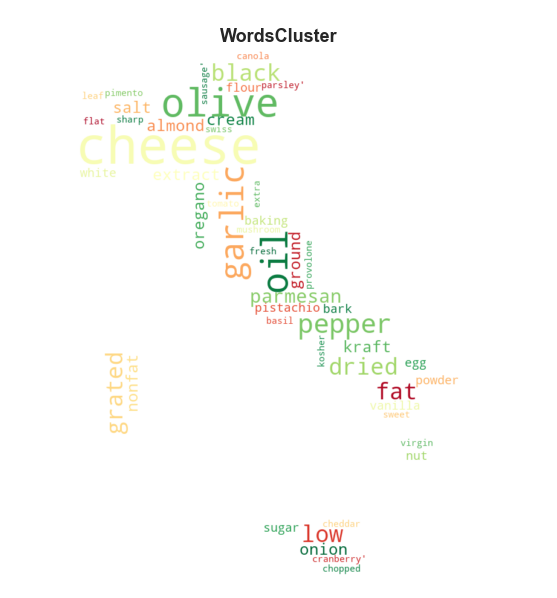

In [123]:
wordcloud = WordCloud(max_font_size=200, max_words=50, background_color="white",
                      mask=ita ,width= 3000, height = 2000,
                      stopwords = stopwords.words('english')).generate(str(italian.final.values))

plot_wordcloud(wordcloud.recolor( colormap= 'RdYlGn' , random_state=17), '\nWords')

d:\anaconda\envs\dataanalytic\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



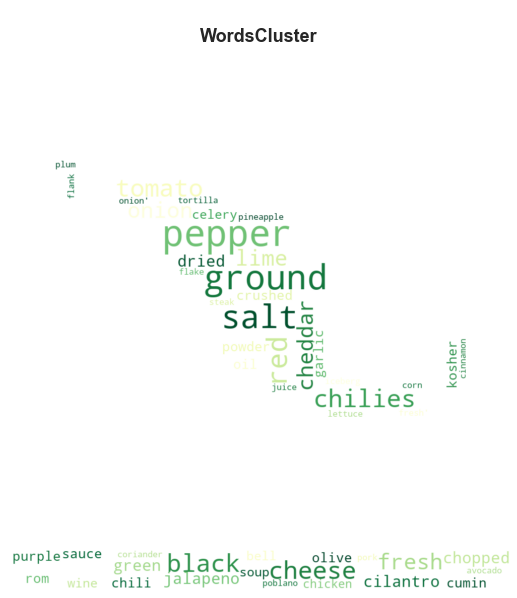

In [124]:
wordcloud = WordCloud(max_font_size=200, max_words=50, background_color="white",
                      mask=mex ,width= 3000, height = 2000,
                      stopwords = stopwords.words('english')).generate(str(mexican.final.values))

plot_wordcloud(wordcloud.recolor( colormap= 'YlGn' , random_state=17), '\nWords')

d:\anaconda\envs\dataanalytic\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



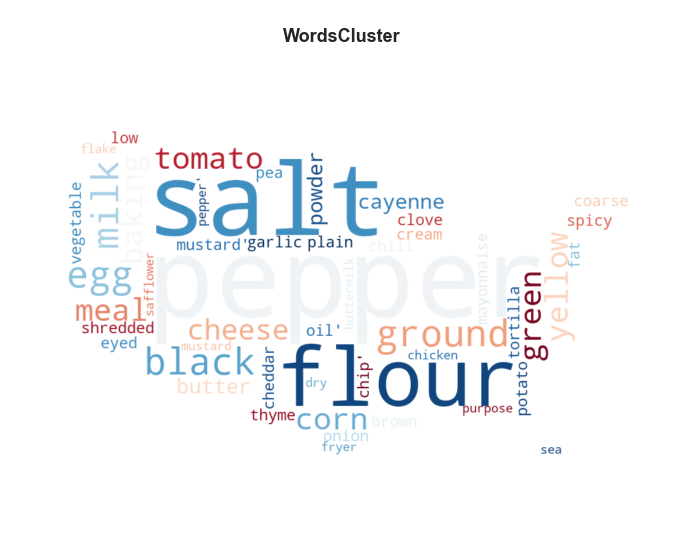

In [125]:
wordcloud = WordCloud(max_font_size=200, max_words=50, background_color="white",
                      mask=sou ,width= 3000, height = 2000,
                      stopwords = stopwords.words('english')).generate(str(southern_us.final.values))

plot_wordcloud(wordcloud.recolor( colormap= 'RdBu' , random_state=17), '\nWords')

d:\anaconda\envs\dataanalytic\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



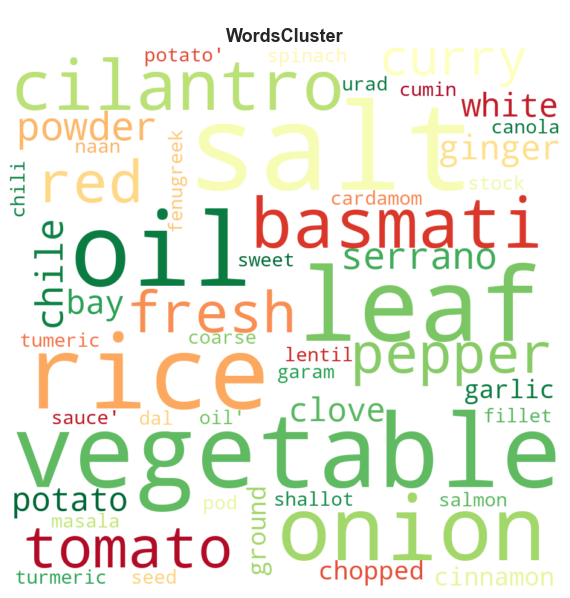

In [126]:
wordcloud = WordCloud(max_font_size=200, max_words=50, background_color="white",
                      mask=ind ,width= 3000, height = 2000,
                      stopwords = stopwords.words('english')).generate(str(indian.final.values))

plot_wordcloud(wordcloud.recolor( colormap= 'RdYlGn' , random_state=17), '\nWords')

d:\anaconda\envs\dataanalytic\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



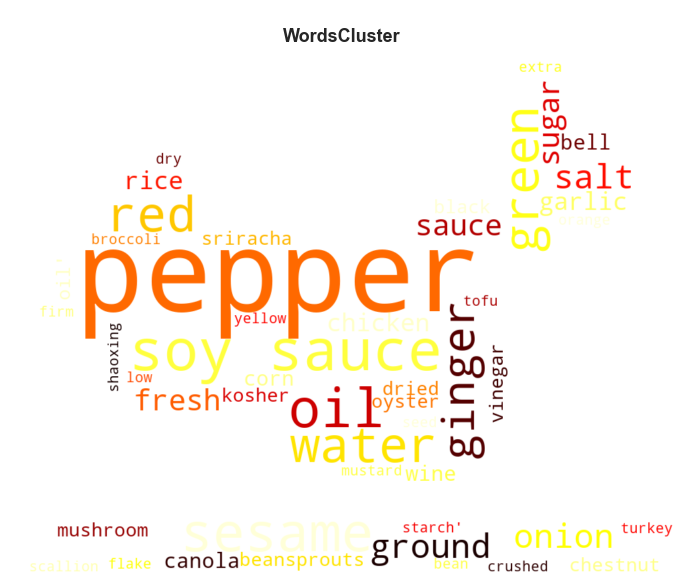

In [127]:
wordcloud = WordCloud(max_font_size=200, max_words=50, background_color="white",
                      mask=chi ,width= 3000, height = 2000,
                      stopwords = stopwords.words('english')).generate(str(chinese.final.values))

plot_wordcloud(wordcloud.recolor( colormap= 'hot' , random_state=17), '\nWords')